# Import libraries

In [3]:
import os 
import re
import csv
import json
import gzip
import math
import time
import pickle
import warnings
import numpy as np
import pandas as pd
import xgboost as xgb
import networkx as nx
from sklearn.svm import SVC
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
from sklearn.cluster import KMeans
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score
from scipy.stats import wasserstein_distance
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.kernel_approximation import RBFSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_kernels
from networkx.algorithms.community import girvan_newman
from sklearn.metrics.pairwise import euclidean_distances
from networkx.algorithms.community.quality import modularity
from networkx.algorithms.community import asyn_lpa_communities
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score,cross_val_predict,cross_validate,StratifiedKFold

warnings.filterwarnings("ignore")

# Pathes

In [15]:
path_to_data_folder = '/Users/abdulnaser/Desktop/Masterarbeit/metadatatransferlearning-main/meta_tl/data/'
path_to_working_dir = '/Users/abdulnaser/Desktop/Masterarbeit/metadatatransferlearning-main/meta_tl/'
path_to_help_data = path_to_data_folder + 'help_data/'
path_to_gt_folder = path_to_data_folder + 'ground_truth_data/music/'
path_to_sim_vectors_folder = path_to_data_folder + 'sim_dataframes/music/'
path_to_data_folder = path_to_working_dir + 'data/'
models_directory = path_to_working_dir + 'models/'
path_to_results_folder = path_to_data_folder + 'results/'
path_to_feature_vectors_folder = path_to_data_folder + 'feature_vectors/'
active_learning_path = path_to_data_folder + 'active_learning/'
path_to_models_folders = path_to_data_folder + 'models/'
folder_path = '/Users/abdulnaser/Desktop/Masterarbeit/metadatatransferlearning-main/meta_tl/data/datasets_predicitons/'
second_approach_predictions_folder_path = "/Users/abdulnaser/Desktop/Masterarbeit/metadatatransferlearning-main/meta_tl/data/First_approach_results/Predictions/music"

# Import data

In [5]:
# Open the JSON file
extracted_data = []
with open('/Users/abdulnaser/Desktop/Masterarbeit/Music/threshold_0.45/vertices.json', 'r') as f:
    # Read each line and parse JSON object
    for line in f:
        try:
            # Parse JSON object
            data = json.loads(line)
            # Extract "id" and "data" fields
            extracted_item = {
                "id": data["id"]
            }
            # Flatten the "data" column into separate columns
            extracted_item.update(data["data"])
            # Append to the list
            extracted_data.append(extracted_item)
            
        except json.JSONDecodeError as e:
            print("Error decoding JSON:", e)
            continue

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(extracted_data)
df = df[['id','title','album','artist','srcId','recId']]
df.to_csv('/Users/abdulnaser/Desktop/Masterarbeit/metadatatransferlearning-main/meta_tl/data/help_data/data_cleaned_music.csv')
df.head()


,id,title,album,artist,srcId,recId
0,58c007cf9184900a77a26089,Daniel Balavoine - L'enfant aux yeux d'Italie,De vous à elle en passant par moi,,2,1
1,58c007cf9184900a77a2608a,007,Cantigas de roda (unknown),[unknown],4,2512/Users/abdulnaser/Desktop/Masterarbeit/met...
2,58c007cf9184900a77a2608b,Action PAINTING! - Mustard Gas,There and Back Again Lane,,2,2
3,58c007cf9184900a77a2608c,Your Grace,Comfort,Kathy Troccoli,5,3
4,58c007cf9184900a77a2608d,Well You Needn't,First Down,Ernie Stadler Jazz Quintet,5,4


# Preprocess the data

In [6]:
df['artist'] = df['artist'].replace('', np.nan)
df['artist'] = df['artist'].replace("[unknown]", np.nan)
df['album'] = df['album'].replace('', np.nan)
df['album'] = df['album'].replace("[unknown]", np.nan)
df['title'] = df['title'].replace('', np.nan)
df['title'] = df['title'].replace("[unknown]", np.nan)

# source_1
source_1 = df.loc[df['srcId']=='1']
source_1['title'] = source_1['title'].str.split('(').str[0]
source_1['title'] = source_1['title'].str.strip()

# source_2 
source_2 = df.loc[df['srcId']=='2']
source_2['artist'] = source_2['title'].str.split('-').str[0].str.strip()
source_2['title'] = source_2['title'].str.split('-').str[1]
source_2['title'] = source_2['title'].str.strip()


# source_3
source_3 = df.loc[df['srcId']=='3']
source_3['title'] = source_3['title'].str.split('-').str[0]

# source_4
source_4 = df.loc[df['srcId']=='4']
source_4['title'] = source_4['title'].str.split('-').str[1]


# source_5
source_5 = df.loc[df['srcId']=='5']


# Record Linkage

### Load dataset

In [7]:
""" Module with functionalities for reading data from a
    file and return a dictionary with record identifieres as
    keys and a list of attribute values
"""

def load_data_set(df):
    """Load the data set and store in memory as a
       dictionary with record identifieres as keys.

       Parameter Description:
       file_name: Name of the data file to be read (CSV or CSV.GZ file)
       rec_id_col: Record identifier column of the data file
       header_line: Availability of the header line (True or False)
    """
    rec_num = 0
    rec_dict = {}

    for index, row in df.iterrows():
        row_dict = {}
        for column_name in df.columns:
            row_dict[column_name] = row[column_name]
        rec_dict[row['id']] = row_dict



    if len(rec_dict) < rec_num:
        print(' *** Warning , data set contains %d duplicates ***' % (rec_num - len(rec_dict)))
        print(' %d unique records ' % (len(rec_dict)))



    # return the generated dictionary of records
    return rec_dict

rec_dict_source_1 = load_data_set(source_1)
rec_dict_source_2 = load_data_set(source_2)
rec_dict_source_3 = load_data_set(source_3)
rec_dict_source_4 = load_data_set(source_4)
rec_dict_source_5 = load_data_set(source_5)

list_of_rec_dicts = []
list_of_rec_dicts.append(rec_dict_source_1)
list_of_rec_dicts.append(rec_dict_source_2)
list_of_rec_dicts.append(rec_dict_source_3)
list_of_rec_dicts.append(rec_dict_source_4)
list_of_rec_dicts.append(rec_dict_source_5)


### Blocking

In [8]:
"""
Mdoule with functionalities for blocking on a
dictionary of records, where a blocking function
must return a dictionary with block idetifiera as
keys and values being sets or lists of record
identifiers in that block.

"""

def blocking(rec_dict, blk_attr_list):
    """ Build the blocking index data structure
        (dictionary) to store blocking key values (BKY)
        as keys and the corresponding list of record
        identifieres.

        A blocking is implemented that simply
        concatenates attribute values.

        Parameter Description:
        rec_dict: Dictionary that holds the record
        identifieres as keys and corresponding list of
        record values

        blk_attr_list: List of blocking key attributes to use.

        This method returns a dictionary with blocking
        key values as its keys and list of record
        identifiers as its values (one list for each block).

        Example:
        If the blocking is based on 'postcode' then:
        block_dict = {'2000': [rec1_id, rec2_id, rec3_id, .....],
                      '2600': [rec4_id, rec5_id,..........]
                      .....
        }

        while if the blocking is based on 'postcode' and 'gender' then:
        block_dict = {'2000f': [rec1_id, rec3_id, ......],
                      '2000m': [rec2_id, ......]
                      '2600m': [rec4_id,.......]
                      ...
        }

    """

    # The dictionary with the blocks to be generated and returned
    block_dict = {}

    #print('Run blocking:')
    #print('List of blocking key attributes: ' + str(blk_attr_list))
    #print('Number of records to be blcoked: ') + str(len(rec_dict))
    #print('')

    for (rec_id , rec_values) in rec_dict.items():

        # Initialise the blocking key values for this record
        rec_bkv = ''

        # Process selected blocking attributes
        for attr in blk_attr_list:

            attr_val = rec_values[attr]
            attr_val = str(attr_val)
            rec_bkv += attr_val[:1]

        # Insert the blocking key value and the record into
        # the blocking dictionary
        if (rec_bkv in block_dict): # Block key value in block index
            # Only need to add the record
            rec_id_list = block_dict[rec_bkv]
            rec_id_list.append(rec_id)

        else: # Block key value not in block index
            # Create a new block and add the record
            # identifier
            rec_id_list = [rec_id]
        block_dict[rec_bkv] = rec_id_list # store the new block

    return block_dict



def printBlockStatistics(BlockA_dict):
    """
     Calculate and print some basics statistics about
     the generated blocks
    """

    #print('Statistics of the generated blocks for {} : '.format(dataset_name))


    numA_blocks = len(BlockA_dict)


    block_sizeA_list = []
    for rec_id_list in BlockA_dict.values(): # Loop over all blocks
        block_sizeA_list.append(len(rec_id_list))

    print('Dataset A number of blocks generated: %d' % (numA_blocks))
    print(' Minimum block size: %d' % (min(block_sizeA_list)))
    print(' Average block size: %.2f' % \
          (float(sum(block_sizeA_list)) / len(block_sizeA_list)))
    print(' maximum block size: %d' % (max(block_sizeA_list)))
    print('')

    
#blocking_attr_list = ['title','album','artist']
blocking_attr_list = ['title']

blocking_dict_source_1 = blocking(rec_dict_source_1,blocking_attr_list)
blocking_dict_source_2 = blocking(rec_dict_source_2,blocking_attr_list)
blocking_dict_source_3 = blocking(rec_dict_source_3,blocking_attr_list)
blocking_dict_source_4 = blocking(rec_dict_source_4,blocking_attr_list)
blocking_dict_source_5 = blocking(rec_dict_source_5,blocking_attr_list)

list_of_blocking_dicts = []
list_of_blocking_dicts.append(blocking_dict_source_1)
list_of_blocking_dicts.append(blocking_dict_source_2)
list_of_blocking_dicts.append(blocking_dict_source_3)
list_of_blocking_dicts.append(blocking_dict_source_4)
list_of_blocking_dicts.append(blocking_dict_source_5)



### Comparison

In [9]:
def dice_comp(val1, val2):
    """Calculate the Dice coefficient similarity between the two given attribute
     values by extracting sets of sub-strings (q-grams) of length q.

     Returns a value between 0.0 and 1.0.
  """
    Q = 3  # Value length of q-grams for Jaccard and Dice comparison function

    is_efficient = False
    is_padding = True
    # If at least one of the values is empty return 0
    #
    if (len(val1) == 0) or (len(val2) == 0):
        return 0.0

    # If both attribute values exactly match return 1
    #
    elif val1 == val2:
        return 1.0
    if not is_efficient:
        if is_padding:
            pad_val_1 = "#" * (Q - 1) + val1 + "#" * (Q - 1)
            pad_val_2 = "#" * (Q - 1) + val2 + "#" * (Q - 1)
        else:
            pad_val_1 = val1
            pad_val_2 = val2
        q_gram_list1 = [pad_val_1[i:i + Q] for i in range(len(pad_val_1) - (Q - 1))]
        q_gram_list2 = [pad_val_2[i:i + Q] for i in range(len(pad_val_2) - (Q - 1))]
        q_gram_set1 = set(q_gram_list1)
        q_gram_set2 = set(q_gram_list2)
    else:
        q_gram_set1 = val1
        q_gram_set2 = val2
    if len(q_gram_set1) == 0 or len(q_gram_set2) == 0:
        return 0
    i = len(q_gram_set1.intersection(q_gram_set2))
    dice_sim = 2.0 * float(i) / float(len(q_gram_set1) + len(q_gram_set2))

    # ************ End of your Dice code ****************************************

    assert 0.0 <= dice_sim <= 1.0

    return dice_sim




def jaccard_comp(val1, val2):
    """Calculate the Jaccard similarity between the two given attribute values
     by extracting sets of sub-strings (q-grams) of length q.

     Returns a value between 0.0 and 1.0.
  """
    # If at least one of the values is empty return 0
    #
    if (len(val1) == 0) or (len(val2) == 0):
        return 0.0

    # If both attribute values exactly match return 1
    #
    elif (val1 == val2):
        return 1.0

    # ********* Implement Jaccard similarity function here *********

    jacc_sim = 0.0  # Replace with your code
    if not is_efficient:
        if is_padding:
            pad_val_1 = "#" * (Q - 1) + val1 + "#" * (Q - 1)
            pad_val_2 = "#" * (Q - 1) + val2 + "#" * (Q - 1)
        else:
            pad_val_1 = val1
            pad_val_2 = val2
        q_gram_list1 = [pad_val_1[i:i + Q] for i in range(len(pad_val_1) - (Q - 1))]
        q_gram_list2 = [pad_val_2[i:i + Q] for i in range(len(pad_val_2) - (Q - 1))]

        q_gram_set1 = set(q_gram_list1)
        q_gram_set2 = set(q_gram_list2)
    else:
        q_gram_set1 = val1
        q_gram_set2 = val2

    i = len(q_gram_set1.intersection(q_gram_set2))
    u = len(q_gram_set1.union(q_gram_set2))
    assert u > 0, u

    jacc_sim = float(i) / u

    # ************ End of your Jaccard code *************************************

    assert jacc_sim >= 0.0 and jacc_sim <= 1.0

    return jacc_sim


# ================================================================
# Function to compare a block

def compareBlocks(blockA_dict, blockB_dict, recA_dict, recB_dict, attr_comp_list,file_name):
    """Build a similarity dictionary with pair of records from the two given
     block dictionaries. Candidate pairs are generated by pairing each record
     in a given block from data set A with all the records in the same block
     from dataset B.

     For each candidate pair a similarity vector is computed by comparing
     attribute values with the specified comparison method.

     Parameter Description:
       blockA_dict    : Dictionary of blocks from dataset A
       blockB_dict    : Dictionary of blocks from dataset B
       recA_dict      : Dictionary of records from dataset A
       recB_dict      : Dictionary of records from dataset B
       attr_comp_list : List of comparison methods for comparing individual
                        attribute values. This needs to be a list of tuples
                        where each tuple contains: (comparison function,
                        attribute number in record A, attribute number in
                        record B).

     This method returns a similarity vector with one similarity value per
     compared record pair.

     Example: sim_vec_dict = {(recA1,recB1) = [1.0,0.0,0.5, ...],
                              (recA1,recB5) = [0.9,0.4,1.0, ...],
                               ...
                             }
    """

    print('Compare %d blocks from dataset A with %d blocks from dataset B' % \
          (len(blockA_dict), len(blockB_dict)))

    print("The sources that we are comparing are ")
    print(file_name)
    sim_vec_dict = {} # A dictionary where keys are record pairs and values
    # lists of similatiry values


    # Iterate through each block in dictionary from dataset A
    for(block_bkv, rec_idA_list) in blockA_dict.items():
        # Check if the same blocking key occurs also for dataset B
        if(block_bkv in blockB_dict):
            # If so get the record identifier list from dataset B
            rec_idB_list = blockB_dict[block_bkv]

            # Compare each record in rec_id_listA with each record from rec_id_listB
            for rec_idA in rec_idA_list:
                recA = recA_dict[rec_idA]

                for rec_idB in rec_idB_list:
                    recB = recB_dict[rec_idB]

                    # generate the similiarty vector
                    sim_vec = compareRecord(recA, recB, attr_comp_list)

                    # Add the similarity vector of the compared pair to the similarity
                    # vector dictionary
                    #
                    sim_vec_dict[(rec_idA, rec_idB)] = sim_vec
    print('  Compared %d record pairs' % (len(sim_vec_dict)))
    print('')

    # save the sim vects as dataframe
    save_similiarty_vectors_into_dataframe(sim_vec_dict,file_name)

    return sim_vec_dict



def compareRecord(recA, recB, attr_comp_list):
    """Generate the similarity vector for the given record pair by comparing
     attribute values according to the comparison function and attribute
     numbers in the given attribute comparison list.

     Parameter Description:
       recA           : List of first record values for comparison
       recB           : List of second record values for comparison
       attr_comp_list : List of comparison methods for comparing attributes,
                        this needs to be a list of tuples where each tuple
                        contains: (comparison function, attribute number in
                        record A, attribute number in record B).

     This method returns a similarity vector with one value for each compared
     attribute.
  """
    sim_vec = []
    # Calculate a similarity for each attribute to be comapred
    #
    for (comp_funct, attr_numA, attr_numB) in attr_comp_list:
        #print("The attributes to compare are :")
        #print(attr_numA)
        #print(attr_numB)
        a_value = recA[attr_numA]
        b_value = recB[attr_numB]

        if a_value == '/':
            valA = '/'

        elif a_value == '' or pd.isnull(a_value):
            valA = '/' # Handle empty string or NaN values

        else:
            valA = recA[attr_numA]


        if b_value == '/':
            valB = '/'

        elif b_value == '' or pd.isnull(b_value):
            valB = '/' # Hanlde empty string or NaN values

        else:
            valB = recB[attr_numB]

        if valA == '/' or valB == '/':
            sim = '/'

        else:
            sim = comp_funct(valA, valB)

        sim_vec.append(sim)

    return sim_vec


def save_similiarty_vectors_into_dataframe(sim_vectors,file_name):

    # Extract keys and values from the dictionray
    keys = list(sim_vectors.keys())
    values = list(sim_vectors.values())


    # create lists to store data for DataFrame columns
    record_1 = [key[0] for key in keys]
    record_2 = [key[1] for key in keys ]

    # Create a dictionary for DataFrame creation
    data = {
        "record_compared_1": record_1,
        "record_compared_2": record_2,
        "title_dice3": [val[0] for val in values],
        "album_dice3": [val[1] for val in values],
        "artist_dice3": [val[2] for val in values]
    }

    # create DataFrame
    df = pd.DataFrame(data)

    # Specify the file path where you want to save the CSV file
    file_path = "/Users/abdulnaser/Desktop/Masterarbeit/metadatatransferlearning-main/meta_tl/data/sim_dataframes/music/" + file_name + ".csv"

    # Save the DataFrame to the specified path as a CSV file
    df.to_csv(file_path, index=False)
    
    
approx_comp_funct_list = [ (dice_comp, 'title', 'title'),
                           (dice_comp, 'album', 'album'),
                           (dice_comp, 'artist', 'artist'),
                         ]
processed_pairs = []
for rec_dict_num1 in range(len(list_of_rec_dicts)):
    for rec_dict_num2 in range(len(list_of_rec_dicts)):
            source_1 = next(iter(list_of_rec_dicts[rec_dict_num1].values())).get('srcId')
            source_2 = next(iter(list_of_rec_dicts[rec_dict_num2].values())).get('srcId')
            if source_1 != source_2:
                source1_source2 = source_1 + "_" + source_2
                source2_source1 = source_2 + "_" + source_1
                if (source1_source2 in processed_pairs) or (source2_source1 in processed_pairs):
                    pass
                else:
                    sim_vec_dict = compareBlocks(list_of_blocking_dicts[rec_dict_num1], list_of_blocking_dicts[rec_dict_num2],
                                                 list_of_rec_dicts[rec_dict_num1], list_of_rec_dicts[rec_dict_num2],
                                                 approx_comp_funct_list,source1_source2)
                    processed_pairs.append(source1_source2)
                    processed_pairs.append(source2_source1)


                           

Compare 167 blocks from dataset A with 163 blocks from dataset B
The sources that we are comparing are 
1_2
  Compared 731002 record pairs

Compare 167 blocks from dataset A with 169 blocks from dataset B
The sources that we are comparing are 
1_3
  Compared 736705 record pairs

Compare 167 blocks from dataset A with 66 blocks from dataset B
The sources that we are comparing are 
1_4
  Compared 691665 record pairs

Compare 167 blocks from dataset A with 164 blocks from dataset B
The sources that we are comparing are 
1_5
  Compared 715427 record pairs

Compare 163 blocks from dataset A with 169 blocks from dataset B
The sources that we are comparing are 
2_3
  Compared 748952 record pairs

Compare 163 blocks from dataset A with 66 blocks from dataset B
The sources that we are comparing are 
2_4
  Compared 708898 record pairs

Compare 163 blocks from dataset A with 164 blocks from dataset B
The sources that we are comparing are 
2_5
  Compared 725634 record pairs

Compare 169 blocks fro

### Gorund truth generation

In [26]:
def ground_truth_data_extractor():
    data = pd.read_csv(path_to_help_data + 'data_cleaned_music.csv')
    path_to_sim_vectors_folder = '/Users/abdulnaser/Desktop/Masterarbeit/metadatatransferlearning-main/meta_tl/data/sim_dataframes/music/'
    for filename in os.listdir('/Users/abdulnaser/Desktop/Masterarbeit/metadatatransferlearning-main/meta_tl/data/sim_dataframes/music'):
        print(filename)
        if filename.endswith(".csv"):

            sim_vec_file_path = os.path.join(path_to_sim_vectors_folder, filename)

            # Read the sim_vec_csv file into a dataframe
            sim_vec_df = pd.read_csv(sim_vec_file_path)

            # Split the string by underscore
            parts = filename.split("_")

            # Extract the two parts
            first_source = int(parts[0])
            second_source = int(parts[1].replace('.csv',''))


            first_source_df = data.loc[data['srcId'] == first_source]
            second_source_df = data.loc[data['srcId'] == second_source]

            # Merge DataFrames on the 'ID' column
            sim_vec_gt_df = pd.merge(first_source_df, second_source_df, on='recId', how='inner')  # 'inner' means use the intersection of keys from both frames

            sim_vec_gt_df = sim_vec_gt_df[['id_x','id_y','recId','recId']]

            # Rename the column names of the ground truth data to match the other columns in the other dataframe to be the merge succefull
            sim_vec_gt_df.rename(columns = {'id_x':'record_compared_1', 'id_y':'record_compared_2'},inplace=True)
            sim_vec_gt_df.rename(columns={'id_x': 'record_compared_1', 'id_y': 'record_compared_2'}, inplace=True)

            sim_vec_gt_df['is_match'] = 1

            # Merge the dataframes on 'record_compared_1' and 'record_compared_2'
            merged_df = pd.merge(sim_vec_df, sim_vec_gt_df, on = ['record_compared_1', 'record_compared_2'], how= 'left')

            # Fill NaN values in 'is_match' column with zeros
            merged_df['is_match'].fillna(0, inplace=True)

            sim_vec_gt_df.to_csv(path_to_gt_folder + filename)
            merged_df.to_csv(os.path.join(path_to_sim_vectors_folder, filename))


ground_truth_data_extractor()

4_5.csv
2_3.csv
2_5.csv
2_4.csv
1_2.csv
1_3.csv
3_5.csv
3_4.csv
1_4.csv
1_5.csv


# Evaluation

# Utils

In [10]:
# Calculate the Euclidean distance between rows
def calculate_distances(row,df, columns_to_consider):        
    distances = euclidean_distances([row[columns_to_consider]],df[columns_to_consider])
    return distances.flatten()
   

# Extract the closest 7 rows and calculate the ratio of 'is_match' values
def calcualte_ratio(row, df,columns_to_consider):
    #print("The following row has the value of 'is_match' {}".format(row['is_match']))
    distances = calculate_distances(row,df,columns_to_consider)
    closest_indices = np.argsort(distances)[1:6] # Exclude the row itself
    closest_rows = df.iloc[closest_indices]
    # Count the occurrences of the same 'is_match' label
    match_count = (closest_rows['is_match'] == row['is_match']).sum()
    
    # Calculate the ratio
    ratio = match_count / len(closest_rows)
                
    return ratio


def del_file(file_path):
    try:
        os.remove(file_path)
        print(f"File {file} deleted successfully.")
    except Exception as e:
        print(f"Error deleting {file_path}: {e}")
    


def delete_files_from_folder(folder_path,files_to_del='ALL'):  
    if files_to_del == 'ALL':
        # List all files in the folder
        files = os.listdir(folder_path)

        # Iterate through the files and delete them
        for file in files:
            file_path = os.path.join(folder_path, file)
            del_file(file_path)
    else:
        full_file_path = os.path.join(folder_path, files_to_del)
        del_file(full_file_path)

        
def get_similairty_value(distances):
    """
    Calculate normalized inverse Euclidean similarity between two lists.

    Parameters:
    - list1: First list
    - list2: Second list

    Returns:
    - Normalized inverse Euclidean similarity (a float between 0 and 1)
    """
    # Check if all distances are zero (identical lists)
    if all(distance == 0 for distance in distances):
        return 1.0  # Identical lists, return maximum similarity

    # Normalize the distances and calculate the average
    max_distance = max(distances)
    normalized_distances = [1 - (distance / max_distance) for distance in distances]
    similarity_score = sum(normalized_distances) / len(normalized_distances)

    return similarity_score
    
  
def compute_mean_similarity(list1, list2):
    # Check if the lists have the same length
    if len(list1) != len(list2):
        raise ValueError("Both lists must have the same length")

    # Calculate absolute differences
    abs_diff = [abs(a - b) for a, b in zip(list1, list2)]

    # Normalize and calculate the mean of absolute differences
    mean_normalized_diff = 1.0 - (sum(abs_diff) / len(list1))

    return mean_normalized_diff


def compute_weighted_mean_similarity(values_list):
    
    weights = [30, 20, 20]
    
    new_values = [1 - x for x in values_list]
    
    indices_of_3 = [index for index, value in enumerate(new_values) if value == 3]
    
    new_values_filtered = [value for index, value in enumerate(new_values) if index not in indices_of_3]
    weights_filtered = [value for index, value in enumerate(weights) if index not in indices_of_3]
    
    weighted_mean_similarity = np.average(new_values_filtered, weights=weights_filtered)
    
    return weighted_mean_similarity


def prepare_dataframe_to_similarity_comparison(file_path):
    
    # Set a threshold for the percentage of NaN values
    threshold_percentage = 70
    
    # Columns to extracte from feature extraction 
    to_consider_columns = ['title_dice3','album_dice3','artist_dice3']
    
    df = pd.read_csv(file_path)
    df = df[to_consider_columns]
    # convert "/" into Nan
    df = df.apply(pd.to_numeric, errors= 'coerce')
    # Filter columns where the percentage of NaN values is over the threshold
    filtered_columns = df.columns[df.isna().mean() < threshold_percentage / 100]
    df = df[filtered_columns]
    
    return df
    
    
def prepare_dataframe(df,resample=False):
    #df.drop(columns=['record_compared_1','record_compared_2','Modell_no_Liste_TruncateBegin20'], axis=1, inplace=True)
    
    df = df[['title_dice3','album_dice3','artist_dice3','is_match']]

    # Replace "/" with 9999 in 'is_match' column
    df.replace('/', 2, inplace=True)
    df.replace('/', np.nan, inplace=True)

    # Convert all columns to numerical data types 
    df = df.apply(pd.to_numeric, errors='coerce')
    
   
    if resample == True:
        # Group the DataFrame by the "is_match" column
        grouped = df.groupby('is_match')

        # Initialize an empty DataFrame to store the sampled data
        sampled_data = pd.DataFrame()
    
        # Iterate over each group
        for group_value, group_df in grouped:
            # If the group_value is 1, sample 50 samples
            if group_value == 1:
                sampled_group = group_df.sample(n=50, random_state=42)  # You can change the random_state if needed
            # If the group_value is 2, sample 1500 samples
            elif group_value == 0:
                sampled_group = group_df.sample(n=10000, random_state=42)  # You can change the random_state if needed
            # Append the sampled group to the sampled data DataFrame
            sampled_data = sampled_data.append(sampled_group)

        # Reset the index of the sampled data DataFrame
        sampled_data.reset_index(drop=True, inplace=True)
        return sampled_data
    
     
    return df


def prepare_dataframe_pred(df):
    #df.drop(columns=['record_compared_1','record_compared_2','Modell_no_Liste_TruncateBegin20'], axis=1, inplace=True)
    
    df = df[['title_dice3','album_dice3','artist_dice3','is_match']]

    # Replace "/" with 9999 in 'is_match' column
    df.replace('/', 2, inplace=True)
    df.replace('/', np.nan, inplace=True)

    # Convert all columns to numerical data types 
    df = df.apply(pd.to_numeric, errors='coerce')
    
    return df


def to_sort_files(files):
    sorted_files = []
    sorted_files.append(files[0])
    for file in sorted_files:
        tmp = similarity_df_first_community_filtered_combined_merged.loc[similarity_df_first_community_filtered_combined_merged['first_file']==file]
        tmp = tmp.loc[tmp['second_file'].isin(files)]
        tmp_sorted = tmp.sort_values(by='avg_sim_val',ascending=False)
        tmp_sorted_files = tmp.sort_values(by='avg_sim_val',ascending=False)['second_file']
        for tmp_sorted_files in tmp_sorted_files:
            if tmp_sorted_files not in sorted_files:
                result = tmp_sorted_files
                sorted_files.append(result)
                break
    
    for file in files:
        if file not in sorted_files:
            sorted_files.append(file)
            
    return sorted_files 
        

def prepare_dataframe_new(df):
    #df.drop(columns=['record_compared_1','record_compared_2','Modell_no_Liste_TruncateBegin20'], axis=1, inplace=True)
    
    df = df[['MPN_Liste_TruncateBegin20','EAN_Liste_TruncateBegin20','Produktname_dic3',
             'Modell_Liste_3g','Digital_zoom_NumMaxProz30','optischer_zoom_NumMaxProz30', 'Breite_NumMaxProz30', 
             'Höhe_NumMaxProz30', 'Gewicht_NumMaxProz30', 'Sensortyp_Jaccard3', 'pred']]

    # Replace "/" with 9999 in 'is_match' column
    df.replace('/', 2, inplace=True)
    df.replace('/', np.nan, inplace=True)

    # Convert all columns to numerical data types 
    df = df.apply(pd.to_numeric, errors='coerce')
    
    return df




def del_files(folder_path):
    files = os.listdir(folder_path)

    # Iterate through the files and remove them
    for file in files:
        file_path = os.path.join(folder_path, file)
        try:
            if os.path.isfile(file_path):
                os.remove(file_path)
                print(f"Removed: {file_path}")
            else:
                print(f"Not a file: {file_path}")
        except Exception as e:
            print(f"Error removing {file_path}: {e}")


            
def is_element_in_lists(list_of_lists, element):
    """
    Check if the given element is present in any of the inner lists.

    Parameters:
    - list_of_lists: A list containing inner lists.
    - element: The element to check for.

    Returns:
    - True if the element is found in any of the inner lists, False otherwise.
    """
    for inner_list in list_of_lists:
        if element in inner_list:
            return True
    return False 



# Function to reverse each row
def reverse_row(row):
    return pd.Series({'first_file': row['second_file'], 'second_file': row['first_file'], 'similiar': row['similiar']})


def get_sim_vec_file_length(file_name):
    file_path = os.path.join(path_to_sim_vector_folder,file_name)
    file_df = pd.read_csv(file_path)
    return file_df.shape[0]


def prepare_dataframe_prediction_new(df):
   
    df = df[['title_dice3','album_dice3','artist_dice3','is_match']]

    # Replace "/" with 9999 in 'is_match' column
    df.replace('/', 2, inplace=True)
    df.replace('/', np.nan, inplace=True)

    # Convert all columns to numerical data types 
    df.iloc[:, 2:] = df.iloc[:, 2:].apply(pd.to_numeric, errors='coerce')
    
    return df


# Main Functions

## Similarity functions

In [11]:
def compute_similarity_ks(case):
    # Initialize dictionaries to store columns and corresponding lists
    column_statistic_lists = {
        'title_dice3': [],
        'album_dice3': [],
        'artist_dice3': []
    }
    first_file = []
    second_file = []
    similiar = []

    # Get a list of all CSV files in the folder 
    csv_files = [file for file in os.listdir(path_to_sim_vector_folder) if file.endswith('.csv')]
    for csv_file_1 in csv_files:
        print(csv_file_1)
        file_path_1 = os.path.join(path_to_sim_vector_folder, csv_file_1)
        df_1 = prepare_dataframe_to_similarity_comparison(file_path_1)
        for csv_file_2 in csv_files:
            file_path_2 = os.path.join(path_to_sim_vector_folder, csv_file_2)
            if file_path_1 != file_path_2:
                print(csv_file_2)
                first_file.append(csv_file_1)
                second_file.append(csv_file_2)
                df_2 = prepare_dataframe_to_similarity_comparison(file_path_2)

                df_1_columns = df_1.columns.tolist()
                df_2_columns = df_2.columns.tolist()

                if df_1_columns == df_2_columns:
                    p_values = []  # Initialize p_values here

                    # Get the intersection of column names
                    intersection_columns = df_1.columns.intersection(df_2.columns)

                    # Create new DataFrames with only the intersecting columns
                    df_1_intersected = df_1[intersection_columns]
                    df_2_intersected = df_2[intersection_columns]

                    for column in column_statistic_lists:
                        # Add -2 to columns in the mapping that are not in the intersected columns
                        if column not in intersection_columns:
                            column_statistic_lists[column].append(-2)

                    for intersected_column in intersection_columns:
                        ks_statistic, ks_p_value = ks_2samp(df_1[intersected_column].dropna(), df_2[intersected_column].dropna())
                        p_values.append(ks_p_value)

                        if intersected_column in column_statistic_lists:
                            # Compute the wasserstein distance
                            wasser_stein_dist = wasserstein_distance(df_1[intersected_column].dropna(), df_2[intersected_column].dropna())
                            #wasser_stein_dist = calculate_psi(df_1[intersected_column].dropna(), df_2[intersected_column].dropna())
                            #wasser_stein_dist = jensen_shannon_divergence(df_1[intersected_column].dropna(), df_2[intersected_column].dropna())
                            column_statistic_lists[intersected_column].append(wasser_stein_dist)

                    alpha = 0.05
                    if case == 1: 
                        # Check if any value is less than the threshold
                        any_value_below_threshold = any(value < alpha for value in p_values)

                        if any_value_below_threshold:
                            similiar.append(0)
                        else:
                            similiar.append(1)
                    else: 
                         count_of_similar_distribution = 0
                
                         for p_val in p_values:
                             if p_val > alpha:
                                count_of_similar_distribution = count_of_similar_distribution + 1

                         if count_of_similar_distribution >= math.ceil(len(p_values) / 2):
                             similiar.append(1)
                                
                         else:
                             similiar.append(0)                 

                else:
                    intersection_columns = df_1.columns.intersection(df_2.columns)
                    df_1_intersected = df_1[intersection_columns]
                    df_2_intersected = df_2[intersection_columns]
                    for column in column_statistic_lists:
                        if column not in intersection_columns:
                            column_statistic_lists[column].append(-2)
                        else: 
                            # Compute the wasserstein distance
                            wasser_stein_dist = wasserstein_distance(df_1[column].dropna(), df_2[column].dropna())
                            #wasser_stein_dist = calculate_psi(df_1[column].dropna(), df_2[column].dropna())
                            #wasser_stein_dist = jensen_shannon_divergence(df_1[column].dropna(), df_2[column].dropna())
                            column_statistic_lists[column].append(wasser_stein_dist)
                           
                        
                    similiar.append(0)

    # Create the final DataFrame
    similarity_df_general = pd.DataFrame({
        'first_file': first_file,
        'second_file': second_file,
        **column_statistic_lists,
        'similiar': similiar
    })

    similarity_df = similarity_df_general.loc[similarity_df_general['similiar']==1]

    similarity_df_general['avg_sim_val'] = similarity_df_general.apply(lambda row: compute_weighted_mean_similarity(row[2:-1]), axis=1)
    similarity_df['avg_sim_val'] = similarity_df.apply(lambda row: compute_weighted_mean_similarity(row[2:-1]), axis=1)

    return similarity_df,similarity_df_general



def compute_similarity_ks_all(case,dataset_with_no_similairty_props):
    first_file = []
    second_file = []
    similiar = []
    p_values = []
   
    # Initialize dictionaries to store columns and corresponding lists
    column_statistic_lists = {  # Dictionary to store lists for each column statistic
        'Produktname_dic3': [],
        'Modell_Liste_3g': [],
        'MPN_Liste_TruncateBegin20': [],
        'EAN_Liste_TruncateBegin20': [],
        'Digital_zoom_NumMaxProz30': [],
        'optischer_zoom_NumMaxProz30': [],
        'Breite_NumMaxProz30': [],
        'Höhe_NumMaxProz30': [],
        'Gewicht_NumMaxProz30': [],
        'Sensortyp_Jaccard3': []
    }

    # Get a list of all CSV files in the folder 
    csv_files = [file for file in os.listdir(path_to_sim_vector_folder) if file.endswith('.csv')]
    for csv_file_1 in csv_files:
        file_path_1 = os.path.join(path_to_sim_vector_folder, csv_file_1)
        df_1 = prepare_dataframe_to_similarity_comparison(file_path_1)
        for csv_file_2 in csv_files:
            file_path_2 = os.path.join(path_to_sim_vector_folder, csv_file_2)
            flag = True
            for i in range(len(first_file)):
                if first_file[i] == csv_file_1 and second_file[i] == csv_file_2:
                    flag = False
            if (file_path_1 != file_path_2) and flag:
                first_file.append(csv_file_1)
                second_file.append(csv_file_2)
                df_2 = prepare_dataframe_to_similarity_comparison(file_path_2)
                df_1_columns = df_1.columns.tolist()
                df_2_columns = df_2.columns.tolist()


                first_bool = csv_file_1 in dataset_with_no_similairty_props['files_original'].tolist()
                second_bool = csv_file_2 in dataset_with_no_similairty_props.loc[dataset_with_no_similairty_props['files_original']== csv_file_1]['files_to_compare_with'].tolist()

                third_bool = csv_file_2 in dataset_with_no_similairty_props['files_original'].tolist()
                fourth_bool = csv_file_1 in dataset_with_no_similairty_props.loc[dataset_with_no_similairty_props['files_original']== csv_file_2]['files_to_compare_with'].tolist()

                if (first_bool and second_bool) or (third_bool and fourth_bool):
                    p_values = []
                    # Get the intersection of column names
                    intersection_columns = df_1.columns.intersection(df_2.columns)

                    # Create new DataFrames with only the intersecting columns
                    df_1_intersected = df_1[intersection_columns]
                    df_2_intersected = df_2[intersection_columns]

                    for column in column_statistic_lists:
                        # Add -2 to columns in the mapping that are not in the intersected columns
                        if column not in intersection_columns:
                            column_statistic_lists[column].append(-2)

                    for intersected_column in intersection_columns:
                        ks_statistic, ks_p_value = ks_2samp(df_1[intersected_column].dropna(), df_2[intersected_column].dropna())
                        p_values.append(ks_p_value)

                        if intersected_column in column_statistic_lists:
                            column_statistic_lists[intersected_column].append(ks_statistic)

                    alpha = 0.05
                    if case == 1: 
                        # Check if any value is less than the threshold
                        any_value_below_threshold = any(value < alpha for value in p_values)

                        if any_value_below_threshold:
                            similiar.append(0)
                        else:
                            similiar.append(1)
                    else: 
                         count_of_similar_distribution = 0
                
                         for p_val in p_values:
                             if p_val > alpha:
                                count_of_similar_distribution = count_of_similar_distribution + 1

                         if count_of_similar_distribution >= math.ceil(len(p_values) / 2):
                             similiar.append(1)
                                
                         else:
                             similiar.append(0)                 



                elif df_1_columns == df_2_columns:
                    p_values = []
                    # Get the intersection of column names
                    intersection_columns = df_1.columns.intersection(df_2.columns)


                    # Create new DataFrames with only the intersecting columns
                    df_1_intersected = df_1[intersection_columns]
                    df_2_intersected = df_2[intersection_columns]

                    for column in column_statistic_lists:
                        # Add -2 to columns in the mapping that are not in the intersected columns
                        if column not in intersection_columns:
                            column_statistic_lists[column].append(-2)

                    for intersected_column in intersection_columns:
                        ks_statistic, ks_p_value = ks_2samp(df_1[intersected_column].dropna(), df_2[intersected_column].dropna())
                        p_values.append(ks_p_value)


                        if intersected_column in column_statistic_lists:
                            column_statistic = column_statistic_lists[intersected_column]
                            column_statistic_lists[intersected_column].append(ks_statistic)

                    alpha = 0.05
                    if case == 1: 
                        # Check if any value is less than the threshold
                        any_value_below_threshold = any(value < alpha for value in p_values)

                        if any_value_below_threshold:
                            similiar.append(0)
                        else:
                            similiar.append(1)
                    else: 
                         count_of_similar_distribution = 0
                
                         for p_val in p_values:
                             if p_val > alpha:
                                count_of_similar_distribution = count_of_similar_distribution + 1

                         if count_of_similar_distribution >= math.ceil(len(p_values) / 2):
                             similiar.append(1)
                                
                         else:
                             similiar.append(0)                 


                else:
                        for column in column_statistic_lists:
                            column_statistic_lists[column].append(0)
                        similiar.append(0)


    # Create the final DataFrame
    similarity_df_general = pd.DataFrame({
        'first_file': first_file,
        'second_file': second_file,
         **column_statistic_lists,
        'similiar': similiar
    })



    similarity_df = similarity_df_general.loc[similarity_df_general['similiar']==1]

    similarity_df_general['avg_sim_val'] = similarity_df_general.apply(lambda row: compute_weighted_mean_similarity(row[2:-1]), axis=1)

    return similarity_df, similarity_df_general



def mmd(X, Y, kernel='rbf', gamma=None):
    """
    Compute the Maximum Mean Discrepancy (MMD) between two sets of samples.

    Parameters:
        X (ndarray): Array of shape (n_samples1, n_features) representing the first set of samples.
        Y (ndarray): Array of shape (n_samples2, n_features) representing the second set of samples.
        kernel (str or callable): Kernel function to use. Default is 'rbf' (Gaussian).
        gamma (float): Parameter for the RBF kernel. If None, it is inferred from data.

    Returns:
        float: The MMD value.
    """
    if kernel == 'squared_exp':
        kernel = 'rbf'  # Squared exponential kernel is equivalent to Gaussian (RBF) kernel
    K_XX = pairwise_kernels(X, X, metric=kernel, gamma=gamma)
    K_YY = pairwise_kernels(Y, Y, metric=kernel, gamma=gamma)
    K_XY = pairwise_kernels(X, Y, metric=kernel, gamma=gamma)

    m = X.shape[0]
    n = Y.shape[0]

    mmd_squared = (1 / (m * (m - 1)) * np.sum(K_XX) -
                   2 / (m * n) * np.sum(K_XY) +
                   1 / (n * (n - 1)) * np.sum(K_YY))
    
    return np.sqrt(mmd_squared)

def mmd_permutation_test(X, Y, num_permutations=100, **kwargs):
    """
    Perform a permutation test to assess the significance of the Maximum Mean Discrepancy (MMD) between two sets of samples.

    Parameters:
        X (ndarray): Array of shape (n_samples1, n_features) representing the first set of samples.
        Y (ndarray): Array of shape (n_samples2, n_features) representing the second set of samples.
        num_permutations (int): Number of permutations to perform.
        **kwargs: Additional keyword arguments to pass to the mmd function.

    Returns:
        float: The p-value of the permutation test.
    """
    mmd_observed = mmd(X, Y, **kwargs)
    combined = np.vstack([X, Y])
    n_samples1 = X.shape[0]
    n_samples2 = Y.shape[0]

    greater_extreme_count = 0
    for _ in range(num_permutations):
        np.random.shuffle(combined)
        X_permuted = combined[:n_samples1]
        Y_permuted = combined[n_samples1:]
        mmd_permuted = mmd(X_permuted, Y_permuted, **kwargs)
        if mmd_permuted >= mmd_observed:
            greater_extreme_count += 1

    return (greater_extreme_count + 1) / (num_permutations + 1)




def calculate_psi(old_results, new_results):
    import numpy as np

    def psi(expected, actual):
        return np.sum((actual - expected) * np.log(actual / expected))

    def calculate_expected(actual):
        return np.mean(actual)

    old_expected = calculate_expected(old_results)
    new_expected = calculate_expected(new_results)

    psi_value = psi(old_expected, new_expected)

    return psi_value



## Graph functions

In [12]:
def create_graph(similarity_df):
    # Create an empty undirected graph
    G = nx.Graph()

    # Add nodes from the 'first_file' and 'second_file' columns
    G.add_nodes_from(similarity_df['first_file'].unique())

    # Add edges from the 'first_file' and 'second_file' columns with weights
    edges = similarity_df[['first_file', 'second_file']].values.tolist()
    #G.add_weighted_edges_from(edges)

    # Relabel nodes to consecutive numbers starting from 1
    mapping = {node: i + 1 for i, node in enumerate(G.nodes)}
    G = nx.relabel_nodes(G, mapping)

    # Relabel edges using the same mapping
    edge_labels = {(mapping[edge[0]], mapping[edge[1]]): edge[2] for edge in edges}
    
    return G,mapping
    

# Preprocessing for Transfer Learning

In [13]:
def tf_pre_processing(community_values,similarity_df,mapping):
    # Extract the similarity relations of the files in the community
    community_keys = [key for key, value in mapping.items() if value in community_values]
    community_similarity_df = similarity_df[(similarity_df['first_file'].isin(community_keys)) & (similarity_df['second_file'].isin(community_keys))]
    
    
    # Compute average similarity between each file and all other combined
    similarity_df_avg_sim = community_similarity_df.groupby(['first_file'])['avg_sim_val'].agg(['mean', 'count']).reset_index()
    similarity_df_avg_sim = similarity_df_avg_sim.sort_values(by=['count', 'mean'], ascending=[False, False])
    similarity_df_avg_sim = similarity_df_avg_sim[['first_file','mean', 'count']]
    similarity_df_avg_sim_merged = pd.merge(community_similarity_df, similarity_df_avg_sim, on='first_file', how='inner')
    similarity_df_avg_sim_merged = similarity_df_avg_sim_merged.rename(columns={'mean': 'overall_mean'})


    # Extract the best datasets to train the model on
    file_belong_to = {}
    unique_community_first_members_names = similarity_df_avg_sim_merged['first_file'].unique()
    for file in unique_community_first_members_names:
        temp_second_members_df = similarity_df_avg_sim_merged.loc[similarity_df_avg_sim_merged['first_file']==file][['second_file','overall_mean']]
        for index, row in temp_second_members_df.iterrows():
             if row['second_file'] not in file_belong_to:
                    file_belong_to[row['second_file']] = [file,row['overall_mean']]
             else:
                    current_overall_mean = file_belong_to[row['second_file']][1]
                    if row['overall_mean'] > current_overall_mean:
                        file_belong_to[row['second_file']] = [file,row['overall_mean']]
           
        
     
    # Extract the best files and their count                    
    files = []
    belong_to = []
    for key, value in file_belong_to.items():
        files.append(value[0])
        belong_to.append(key)
        
        
    cluster_files_df = pd.DataFrame({'first_file': files, 'belong_to': belong_to})
    cluster_files_df = pd.merge(cluster_files_df, similarity_df_avg_sim, on='first_file', how='inner')
    cluster_files_df_grouped = cluster_files_df.groupby(['first_file','mean']).count().reset_index()
    cluster_files_df_grouped = cluster_files_df_grouped.sort_values(by='count', ascending=False)
    cluster_files_df_sorted = cluster_files_df.sort_values(by='mean', ascending = False).reset_index()
    
    
    # Remove reversed similarities
    columns = ['first_file', 'belong_to', 'mean_val', 'count_val']
    df = pd.DataFrame(columns=columns)

    # Iterate over each row in the DataFrame
    for index, row in cluster_files_df_sorted.iterrows():
        len_tmp = df.loc[(df['first_file']==row['belong_to']) & (df['belong_to']==row['first_file'])].shape[0]

        if(len_tmp==0):
            row_data = {'first_file': row['first_file'], 'belong_to': row['belong_to'], 'mean_val':row['mean'],'count_val':row['count']}
            df = df.append(row_data, ignore_index=True)


    cluster_files_df_grouped = df.groupby(['first_file','mean_val']).count().reset_index()
    cluster_files_df_grouped = cluster_files_df_grouped.sort_values(by='belong_to', ascending=False)
   
    return cluster_files_df_grouped,df



def tf_pre_processing_new(community_values,similarity_df,mapping):
    community_keys = [key for key, value in mapping.items() if value in community_values]
    community_similarity_df = similarity_df[(similarity_df['first_file'].isin(community_keys)) & (similarity_df['second_file'].isin(community_keys))]

    # Compute average similarity between each file and all other combined
    similarity_df_avg_sim = community_similarity_df.groupby(['first_file'])['avg_sim_val'].agg(['mean', 'count']).reset_index()
    similarity_df_avg_sim = similarity_df_avg_sim.sort_values(by=['count', 'mean'], ascending=[False, False])
    similarity_df_avg_sim = similarity_df_avg_sim[['first_file','mean', 'count']]
    similarity_df_avg_sim_merged = pd.merge(community_similarity_df, similarity_df_avg_sim, on='first_file', how='inner')
    similarity_df_avg_sim_merged = similarity_df_avg_sim_merged.rename(columns={'mean': 'overall_mean'})
    similarity_df_avg_sim_merged['first_file_count'] = similarity_df_avg_sim_merged['first_file'].map(get_sim_vec_file_length)
    similarity_df_avg_sim_merged['second_file_count'] = similarity_df_avg_sim_merged['second_file'].map(get_sim_vec_file_length)

    # Extract the best datasets to train the model on
    file_belong_to = {}
    unique_community_first_members_names = similarity_df_avg_sim_merged['first_file'].unique()
    for file in unique_community_first_members_names:
        temp_second_members_df = similarity_df_avg_sim_merged.loc[similarity_df_avg_sim_merged['first_file']==file][['second_file','overall_mean','first_file_count']]
        for index, row in temp_second_members_df.iterrows():
             if row['second_file'] not in file_belong_to:
                    file_belong_to[row['second_file']] = [file,row['overall_mean'],row['first_file_count']]
             else:
                    current_best_mean = file_belong_to[row['second_file']][1]
                    current_best_count = file_belong_to[row['second_file']][2]
                    if (row['overall_mean'] >= current_best_mean and row['first_file_count']>=300 and row['first_file_count']<=500) or ((current_best_count > 200) and row['first_file_count']>=80 and row['first_file_count']<=200):
                        file_belong_to[row['second_file']] = [file,row['overall_mean'],row['first_file_count']]


    # Extract the best files and their count                    
    files = []
    belong_to = []
    for key, value in file_belong_to.items():
        files.append(value[0])
        belong_to.append(key)


    cluster_files_df = pd.DataFrame({'first_file': files, 'belong_to': belong_to})
    cluster_files_df = pd.merge(cluster_files_df, similarity_df_avg_sim, on='first_file', how='inner')
    cluster_files_df_grouped = cluster_files_df.groupby(['first_file','mean']).count().reset_index()
    cluster_files_df_grouped = cluster_files_df_grouped.sort_values(by='count', ascending=False)
    cluster_files_df_sorted = cluster_files_df.sort_values(by='mean', ascending = False).reset_index()

    # Remove reversed similarities
    columns = ['first_file', 'belong_to', 'mean_val', 'count_val']
    df = pd.DataFrame(columns=columns)

    # Iterate over each row in the DataFrame
    for index, row in cluster_files_df_sorted.iterrows():
        len_tmp = df.loc[(df['first_file']==row['belong_to']) & (df['belong_to']==row['first_file'])].shape[0]

        if(len_tmp==0):
            row_data = {'first_file': row['first_file'], 'belong_to': row['belong_to'], 'mean_val':row['mean'],'count_val':row['count']}
            df = df.append(row_data, ignore_index=True)


    cluster_files_df_grouped = df.groupby(['first_file','mean_val']).count().reset_index()
    cluster_files_df_grouped = cluster_files_df_grouped.sort_values(by='belong_to', ascending=False)
    
    return cluster_files_df_grouped,df



def prepare_dataframe_supervised_approach(df):
    df = df[['title_dice3','album_dice3','artist_dice3','is_match','pred']]
    # Replace "/" with 9999 in 'is_match' column
    df.replace('/', 2, inplace=True)
    df.replace('/', np.nan, inplace=True)

    # Convert all columns to numerical data types 
    df = df.apply(pd.to_numeric, errors='coerce')
    return df


def average_difference(list1, list2):
    # Zip the lists together and calculate absolute differences
    differences = [abs(x - y) for x, y in zip(list1, list2)]
    
    # Calculate the average difference
    average_diff = sum(differences) / len(differences)
    
    return average_diff
         

# KS-Test 

## 1. Compute Similarity between each two datasets based on the most available Features

### 1.1 Compute Similarity

In [18]:
path_to_sim_vector_folder = '/Users/abdulnaser/Desktop/Masterarbeit/metadatatransferlearning-main/meta_tl/data/sim_dataframes/music/'
sim_vector_files = [file for file in os.listdir('/Users/abdulnaser/Desktop/Masterarbeit/metadatatransferlearning-main/meta_tl/data/sim_dataframes/music') if file.endswith('.csv')]
for sim_vector_file in sim_vector_files:
    sim_vector_file_path = os.path.join(path_to_sim_vector_folder,sim_vector_file)
    df = pd.read_csv(sim_vector_file_path)
    
    if df.empty:
       os.remove(sim_vector_file_path)
       
sim_vector_files = [file for file in os.listdir(path_to_sim_vector_folder) if file.endswith('.csv')]
print(f"After the delete Process , the Number of sim vector files that have data is {len(sim_vector_files)}")


After the delete Process , the Number of sim vector files that have data is 10


In [27]:
# Record the start time
start_time = time.time()

# Your code here
similarity_df, similarity_df_general = compute_similarity_ks(1)

# Record the end time
end_time = time.time()

# Calculate the execution time in seconds
execution_time_seconds = end_time - start_time

# Convert execution time to minutes
execution_time_minutes = execution_time_seconds / 60

print("Execution time:", execution_time_minutes, "minutes")

4_5.csv
2_3.csv
2_5.csv
2_4.csv
1_2.csv
1_3.csv
3_5.csv
3_4.csv
1_4.csv
1_5.csv
2_3.csv
4_5.csv
2_5.csv
2_4.csv
1_2.csv
1_3.csv
3_5.csv
3_4.csv
1_4.csv
1_5.csv
2_5.csv
4_5.csv
2_3.csv
2_4.csv
1_2.csv
1_3.csv
3_5.csv
3_4.csv
1_4.csv
1_5.csv
2_4.csv
4_5.csv
2_3.csv
2_5.csv
1_2.csv
1_3.csv
3_5.csv
3_4.csv
1_4.csv
1_5.csv
1_2.csv
4_5.csv
2_3.csv
2_5.csv
2_4.csv
1_3.csv
3_5.csv
3_4.csv
1_4.csv
1_5.csv
1_3.csv
4_5.csv
2_3.csv
2_5.csv
2_4.csv
1_2.csv
3_5.csv
3_4.csv
1_4.csv
1_5.csv
3_5.csv
4_5.csv
2_3.csv
2_5.csv
2_4.csv
1_2.csv
1_3.csv
3_4.csv
1_4.csv
1_5.csv
3_4.csv
4_5.csv
2_3.csv
2_5.csv
2_4.csv
1_2.csv
1_3.csv
3_5.csv
1_4.csv
1_5.csv
1_4.csv
4_5.csv
2_3.csv
2_5.csv
2_4.csv
1_2.csv
1_3.csv
3_5.csv
3_4.csv
1_5.csv
1_5.csv
4_5.csv
2_3.csv
2_5.csv
2_4.csv
1_2.csv
1_3.csv
3_5.csv
3_4.csv
1_4.csv
Execution time: 2.958746580282847 minutes


### The ks test resulted in dissimilarities in all tests , which is expected as the test is very sensitive to large datasets and small changes in the data

### Wasserstein_distance?

In [28]:
similarity_df_general.loc[similarity_df_general['avg_sim_val']>0.90,'similiar']=1
similarity_df = similarity_df_general.loc[similarity_df_general['similiar']==1]
print(f"The number of featur vector datasets that have at least one simialr feature vector dataset is {len(similarity_df.loc[similarity_df['similiar']==1]['first_file'].unique())}")
print(f"The shape of the similarity_df is {similarity_df.shape[0]}")

The number of featur vector datasets that have at least one simialr feature vector dataset is 10
The shape of the similarity_df is 90


### According to the Wasserstein_distance there are connection between each pair of feature vector datasest

### ML-Based similarity detection approach? 

In [30]:
first_file = []
second_file = []
cv_scores = []
sim_vector_files = [file for file in os.listdir('/Users/abdulnaser/Desktop/Masterarbeit/metadatatransferlearning-main/meta_tl/data/sim_dataframes/music') if file.endswith('.csv')]
count = 1
for sim_vector_file in sim_vector_files:
    print(sim_vector_file)
    df_4_5 = pd.read_csv(os.path.join('/Users/abdulnaser/Desktop/Masterarbeit/metadatatransferlearning-main/meta_tl/data/sim_dataframes/music',sim_vector_file))
    for sim_vector_file_2 in sim_vector_files:
        if sim_vector_file != sim_vector_file_2:
            first_file.append(sim_vector_file)
            second_file.append(sim_vector_file_2)
            df_3_5 = pd.read_csv(os.path.join('/Users/abdulnaser/Desktop/Masterarbeit/metadatatransferlearning-main/meta_tl/data/sim_dataframes/music',sim_vector_file_2))
            candidate_model_df_processed_4_5 = prepare_dataframe(df_4_5)
            candidate_model_df_processed_3_5 = prepare_dataframe(df_3_5)
            candidate_model_df_processed_4_5['is_match'] = 0
            candidate_model_df_processed_3_5['is_match'] = 1

            # Shuffle the rows of each DataFrame randomly
            df1_shuffled = candidate_model_df_processed_4_5.sample(frac=1, random_state=42)  # Shuffle df1
            df2_shuffled = candidate_model_df_processed_3_5.sample(frac=1, random_state=42)  # Shuffle df2
            #print(df1_shuffled.shape[0])
            #print(df2_shuffled.shape[0])
            # Concatenate the shuffled DataFrames
            concatenated_df = pd.concat([df1_shuffled, df2_shuffled], ignore_index=True)
            #print(concatenated_df.shape[0])
            X = concatenated_df.drop(columns=['is_match'])
            y = concatenated_df['is_match']

            # Create an XGBoost classifier
            xgb_clf = xgb.XGBClassifier(objective='binary:logistic')

            # Perform cross-validation
            cv_results = cross_val_score(xgb_clf, X, y, cv=5, scoring='accuracy')
            cv_scores.append(cv_results.mean())
            


# Create a dictionary from the lists
data = {
    'first_file': first_file,
    'second_file': second_file,
    'cv_scores': cv_scores
}

# Create the DataFrame
df = pd.DataFrame(data)


4_5.csv
2_3.csv
2_5.csv
2_4.csv
1_2.csv
1_3.csv
3_5.csv
3_4.csv
1_4.csv
1_5.csv


In [48]:
df.loc[df['first_file']=='3_5.csv']

,first_file,second_file,cv_scores
54,3_5.csv,4_5.csv,0.973811
55,3_5.csv,2_3.csv,0.509140
56,3_5.csv,2_5.csv,0.973687
57,3_5.csv,2_4.csv,0.973283
58,3_5.csv,1_2.csv,0.973059
59,3_5.csv,1_3.csv,0.518056
60,3_5.csv,3_4.csv,0.511404
61,3_5.csv,1_4.csv,0.973256
62,3_5.csv,1_5.csv,0.973810


In [31]:
similarity_df = df.loc[df['cv_scores']<0.80]
similarity_df['cv_scores'] = 1 - similarity_df['cv_scores']
similarity_df.rename(columns={'cv_scores': 'avg_sim_val'}, inplace=True)

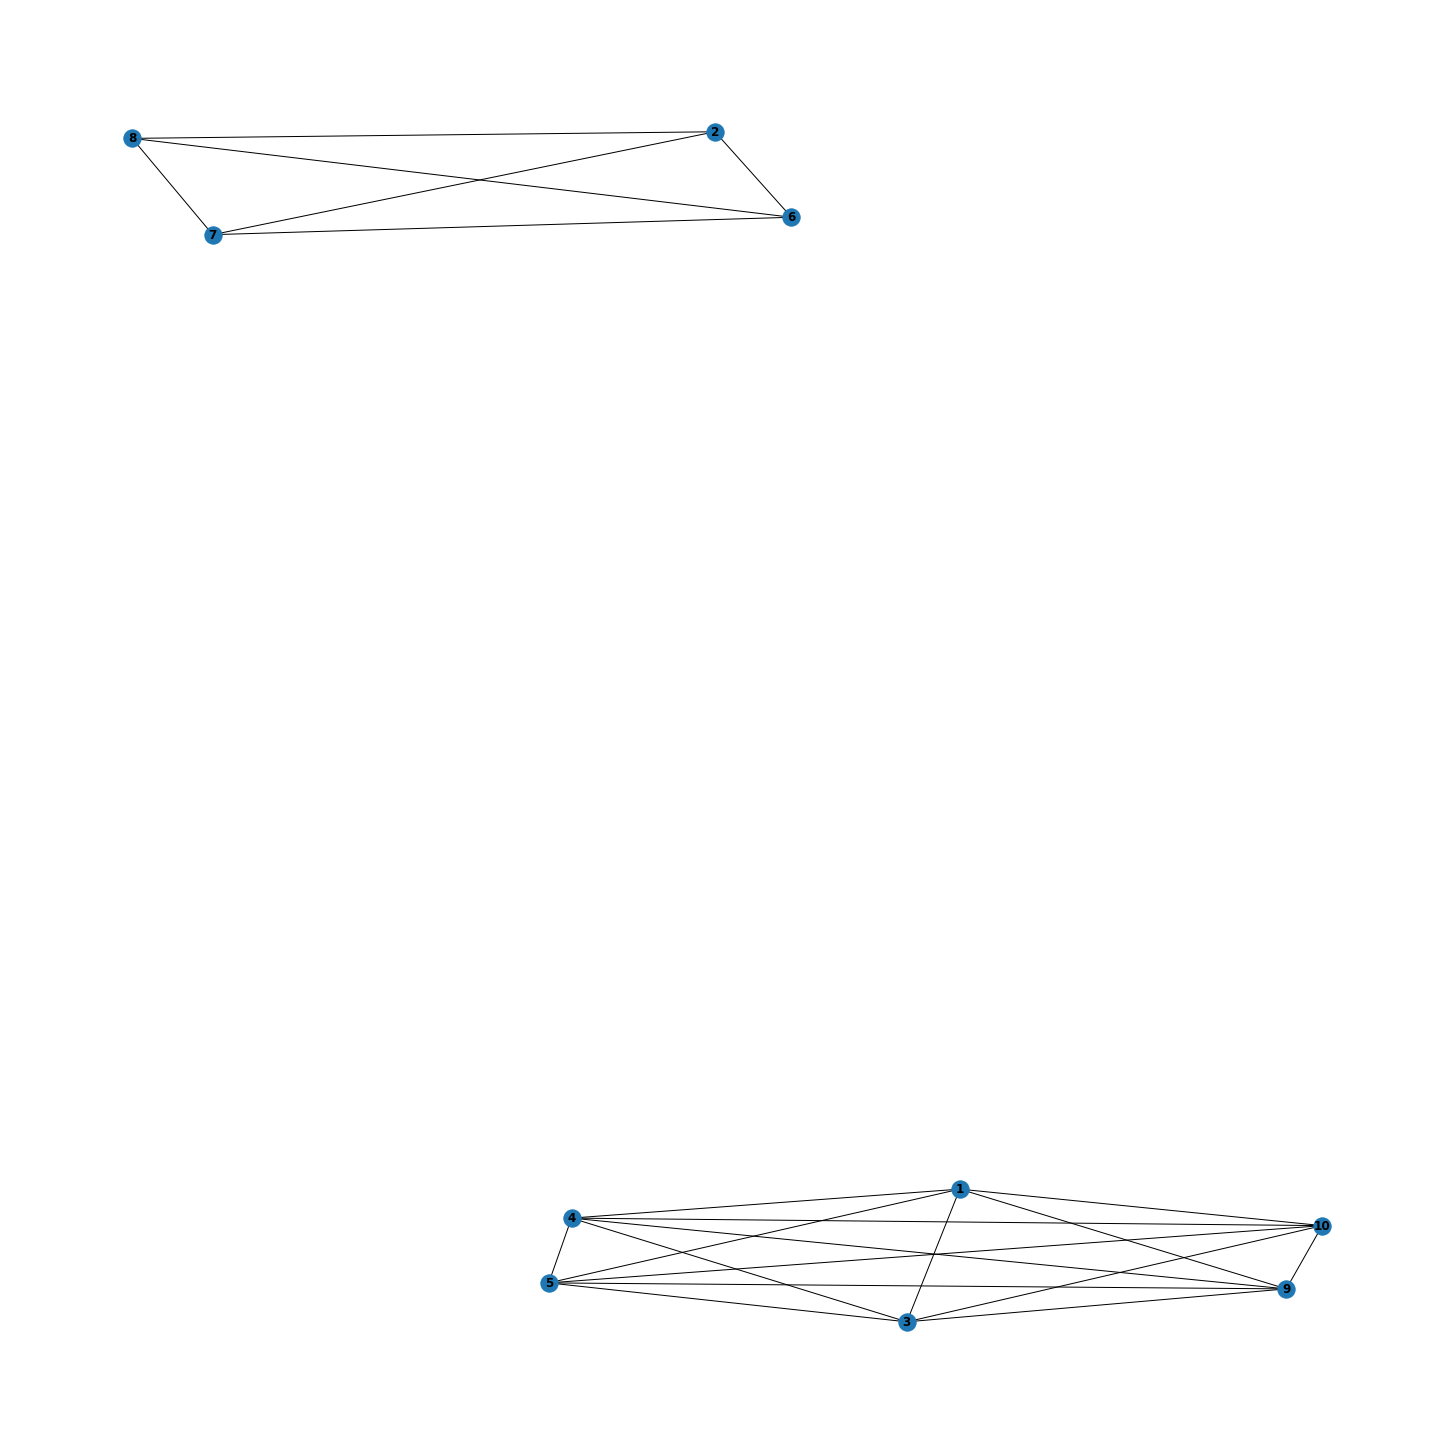

In [32]:
# Create an empty undirected graph
G = nx.Graph()

# Add nodes from the 'first_file' and 'second_file' columns
G.add_nodes_from(similarity_df['first_file'].unique())

# Add edges from the 'first_file' and 'second_file' columns with weights
edges = similarity_df[['first_file', 'second_file']].values.tolist()
G.add_edges_from(edges)

# Relabel nodes to consecutive numbers starting from 1
mapping = {node: i + 1 for i, node in enumerate(G.nodes)}
G = nx.relabel_nodes(G, mapping)

# Set the figure size
plt.figure(figsize=(20, 20))

# Visualize the graph
pos = nx.spring_layout(G)  # Adjust the layout method if needed
nx.draw(G, pos=pos, with_labels=True, font_weight='bold')

plt.show()


[{1, 3, 4, 5, 9, 10}, {8, 2, 6, 7}]


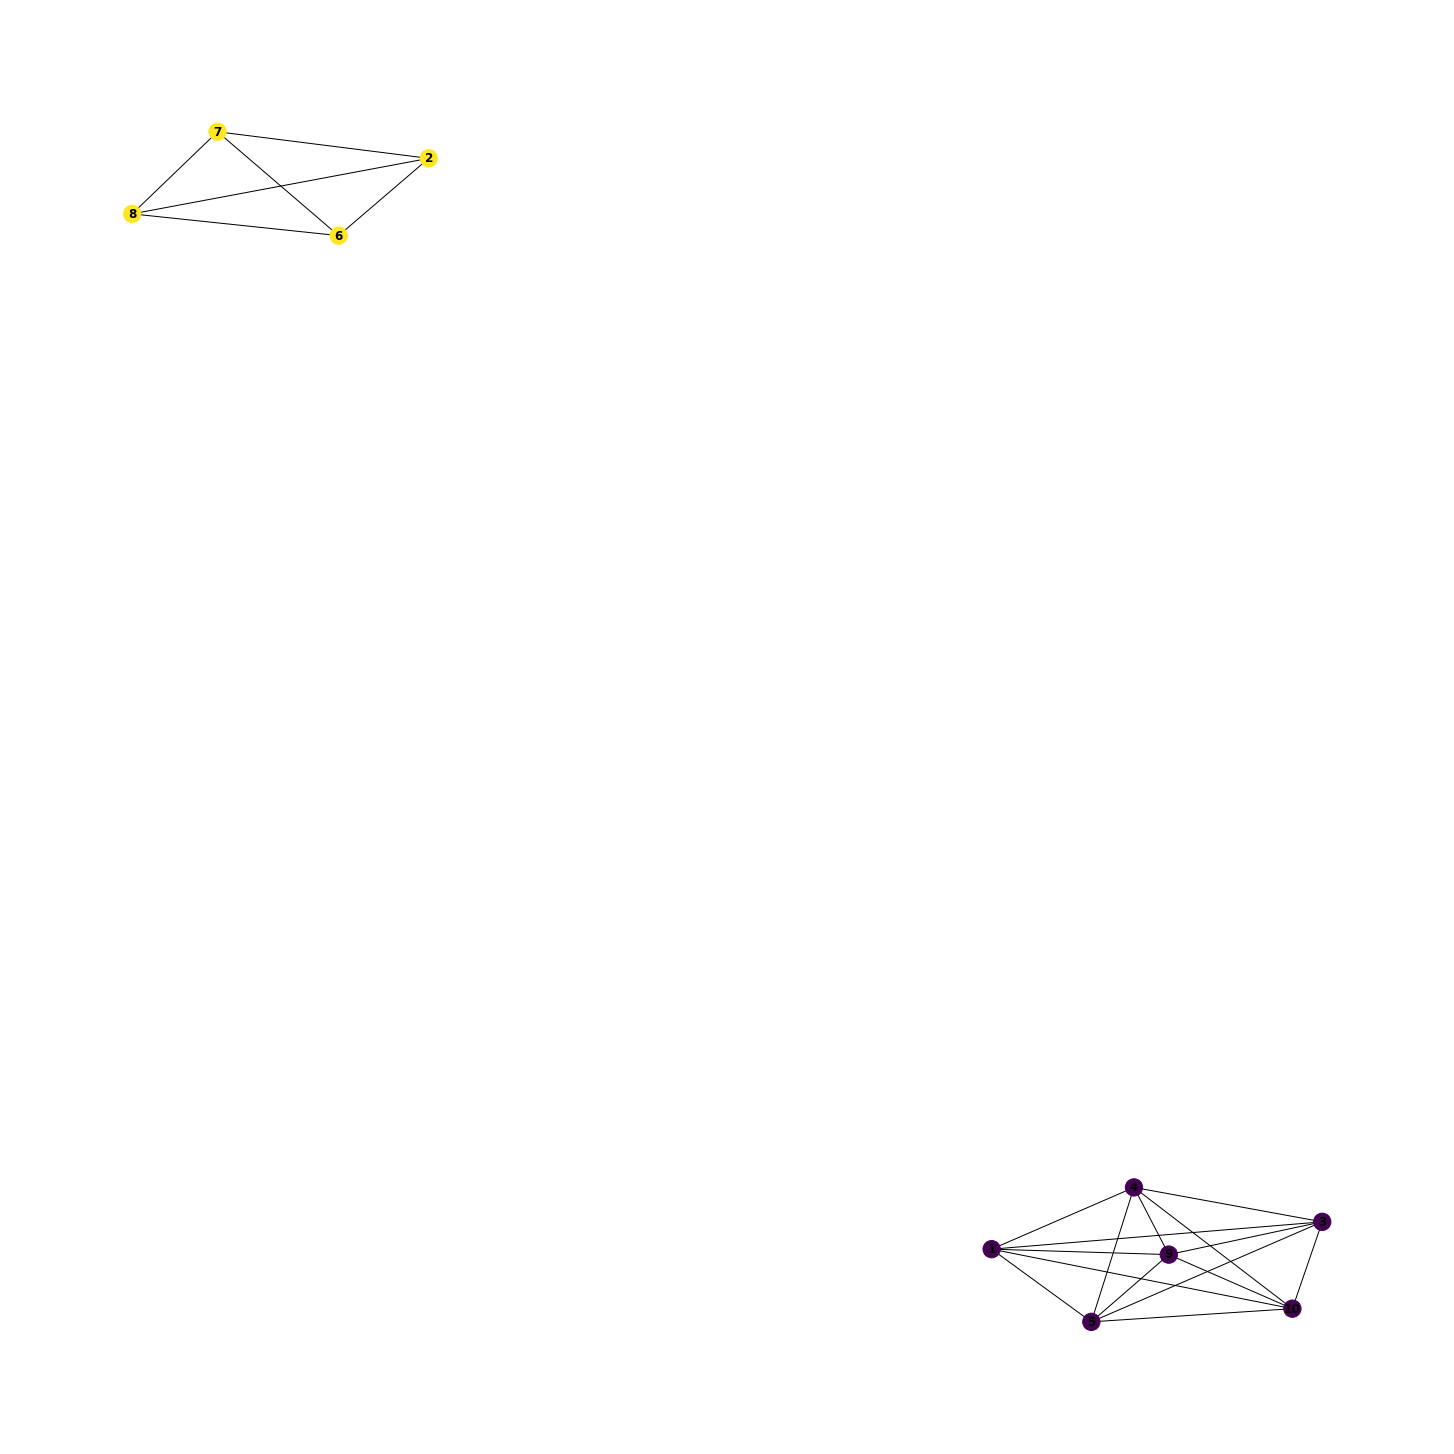

In [33]:
# Detect communities using asynchronous label propagation
communities = list(asyn_lpa_communities(G))
print(communities)
# Assign community labels to nodes
community_labels = {node: idx for idx, nodes in enumerate(communities) for node in nodes}
# Set the figure size
plt.figure(figsize=(20, 20))

# Visualize the graph with community colors
node_colors = [community_labels[node] for node in G.nodes]
nx.draw(G, pos=nx.spring_layout(G), with_labels=True, font_weight='bold', node_color=node_colors, cmap=plt.cm.get_cmap("viridis"))

plt.show()


[{1, 3, 4, 5, 9, 10}, {8, 2, 6, 7}]
Modularity: 0.40816326530612246


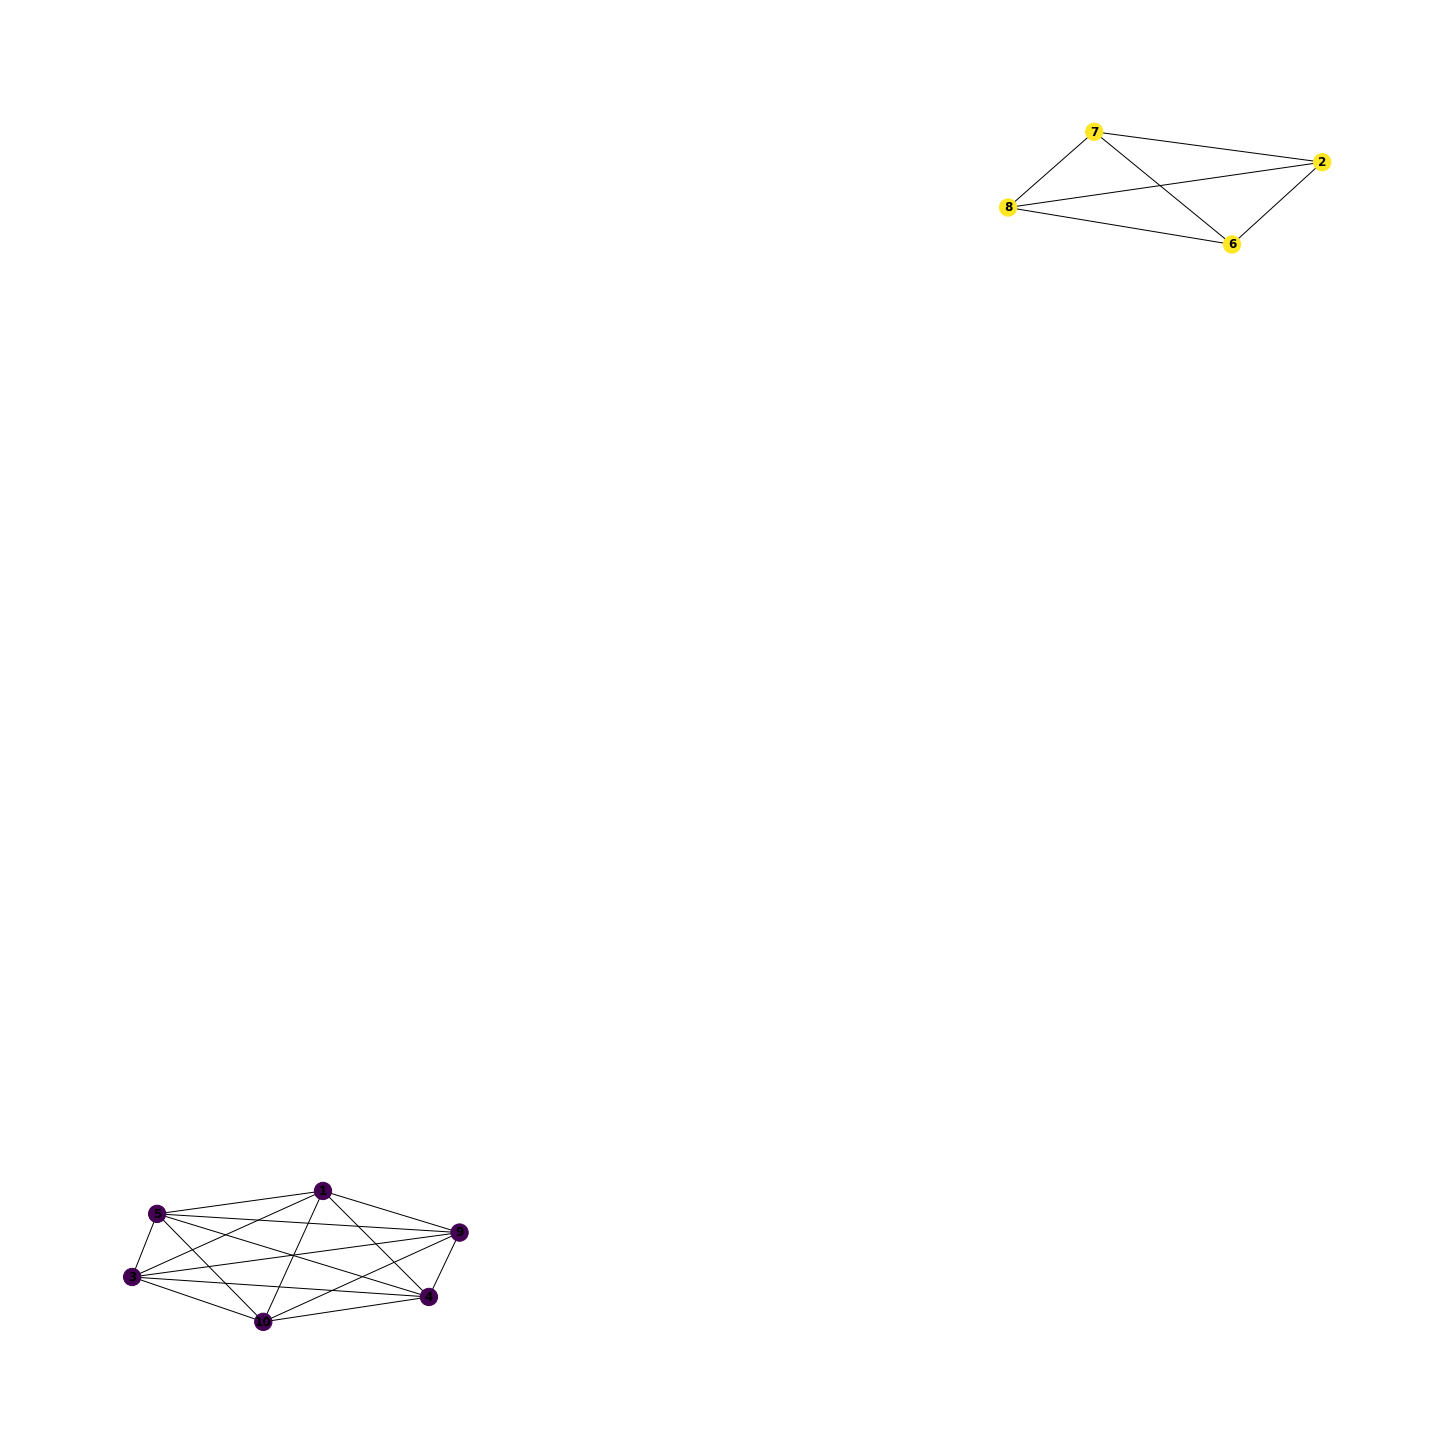

In [49]:
# Detect communities using asynchronous label propagation
communities = list(asyn_lpa_communities(G))
print(communities)

# Assign community laabels to nodes
community_labels = {node: idx for idx, nodes in enumerate(communities) for node in nodes}

# Calculate modularity
mod = modularity(G, communities)
print("Modularity:", mod)


# Set the figure size
plt.figure(figsize=(20, 20))

# Visualize the graph with community colors
node_colors = [community_labels[node] for node in G.nodes]
nx.draw(G, pos=nx.spring_layout(G), with_labels=True, font_weight='bold', node_color=node_colors, cmap=plt.cm.get_cmap("viridis"))

plt.show()


# Training

In [111]:
def active_learning(df):
    
    # Select 20 instances with label 1
    labeled_df_1 = df[df['is_match'] == 1].sample(n=20, random_state=42)

    # Select 20 instances with label 0
    labeled_df_0 = df[df['is_match'] == 0].sample(n=20, random_state=42)

    # Concatenate the two DataFrames to create your labeled dataset
    labeled_df = pd.concat([labeled_df_1, labeled_df_0])
  
    # Remove the selected instances from the original DataFrame to create the unlabeled dataset
    unlabeled_df = df.drop(labeled_df.index)
    
    # Train initial model
    X_train, y_train = labeled_df.drop('is_match', axis=1), labeled_df['is_match']
    model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
    model.fit(X_train, y_train)
    count = 1
    # Active learning loop
    while len(unlabeled_df) > 0:
        print(count)
        #print(count)
        # Predict labels for unlabeled instances
        y_unlabeled = unlabeled_df['is_match']
        X_unlabeled = unlabeled_df.drop('is_match', axis=1)
        predictions = model.predict(X_unlabeled)

        unlabeled_df['predictions'] = predictions
        unlabeled_df[['probabilties_0', 'probabilties_1']] =  model.predict_proba(X_unlabeled)
        unlabeled_df['diff'] = abs(unlabeled_df['probabilties_0']- unlabeled_df['probabilties_1'])
        #print(f1_score(unlabeled_df['is_match'], unlabeled_df['predictions']))
        
        unlabeled_df = unlabeled_df.sort_values(by='diff', ascending=True)
        labeled_instances = unlabeled_df.head(5)
        #print(labeled_instances['diff'])
        
        if(count == 80):
            columns_to_keep = ['title_dice3','album_dice3','artist_dice3','is_match']
            labeled_instances = labeled_instances[columns_to_keep]
            labeled_df = pd.concat([labeled_df, labeled_instances])
            unlabeled_df = unlabeled_df.drop(unlabeled_df.index[:5])
            
            columns_to_drop = ['title_dice3','album_dice3','artist_dice3','predictions']
            #labeled_df.drop(columns=columns_to_drop, inplace=True)
            unlabeled_df  = unlabeled_df[columns_to_drop]
            unlabeled_df.rename(columns={'predictions': 'is_match'}, inplace=True)
            all_dataframe = pd.concat([labeled_df, unlabeled_df])
            
            return all_dataframe,labeled_df.shape[0]
        
        columns_to_keep = ['title_dice3','album_dice3','artist_dice3','is_match']
        labeled_instances = labeled_instances[columns_to_keep]
        print(labeled_df.shape[0]+5)
        labeled_df = pd.concat([labeled_df, labeled_instances])
        unlabeled_df = unlabeled_df.drop(unlabeled_df.index[:5])
        # Drop multiple columns
        columns_to_drop = ['predictions','probabilties_0','probabilties_1','diff']
        unlabeled_df = unlabeled_df[columns_to_keep]
        # Retrain the model
        X_train, y_train = labeled_df.drop('is_match', axis=1), labeled_df['is_match']
        model.fit(X_train, y_train)
        count = count + 1

In [112]:
csv_files = [file for file in os.listdir(path_to_sim_vector_folder) if file.endswith('.csv')]
# List to store dataframes
dfs = []

# Iterate over files in the directory
for filename in csv_files:
    if filename.endswith('.csv'):
        filepath = os.path.join(path_to_sim_vector_folder, filename)
        # Read CSV file into DataFrame
        df = pd.read_csv(filepath)
        # Append DataFrame to list
        dfs.append(df)

# Concatenate all DataFrames into one
combined_df = pd.concat(dfs, ignore_index=True)
combined_df = prepare_dataframe(combined_df)
combined_df,count_n = active_learning(combined_df)


1
45
2
50
3
55
4
60
5
65
6
70
7
75
8
80
9
85
10
90
11
95
12
100
13
105
14
110
15
115
16
120
17
125
18
130
19
135
20
140
21
145
22
150
23
155
24
160
25
165
26
170
27
175
28
180
29
185
30
190
31
195
32
200
33
205
34
210
35
215
36
220
37
225
38
230
39
235
40
240
41
245
42
250
43
255
44
260
45
265
46
270
47
275
48
280
49
285
50
290
51
295
52
300
53
305
54
310
55
315
56
320
57
325
58
330
59
335
60
340
61
345
62
350
63
355
64
360
65
365
66
370
67
375
68
380
69
385
70
390
71
395
72
400
73
405
74
410
75
415
76
420
77
425
78
430
79
435
80


In [113]:
combined_df.rename(columns={'is_match': 'preds'}, inplace=True)
combined_df.head()

,title_dice3,album_dice3,artist_dice3,preds
5722290,0.920635,2.000000,1.0,1.0
4960293,0.897959,2.000000,1.0,1.0
5006379,0.666667,2.000000,1.0,1.0
2719108,1.000000,0.641509,1.0,1.0
3415637,1.000000,1.000000,1.0,1.0


In [114]:
csv_files = [file for file in os.listdir(path_to_sim_vector_folder) if file.endswith('.csv')]
# List to store dataframes
dfs = []

# Iterate over files in the directory
for filename in csv_files:
    if filename.endswith('.csv'):
        filepath = os.path.join(path_to_sim_vector_folder, filename)
        # Read CSV file into DataFrame
        df = pd.read_csv(filepath)
        # Append DataFrame to list
        dfs.append(df)

# Concatenate all DataFrames into one
combined_df_new = pd.concat(dfs, ignore_index=True)

In [115]:
combined_df['is_match'] = combined_df_new['is_match']

In [116]:
from sklearn.metrics import f1_score
print(f1_score(combined_df['is_match'], combined_df['preds']))

0.9870731625423899


In [83]:
# All file in the "Prediction" folder should be deleted
del_files("/Users/abdulnaser/Desktop/Masterarbeit/metadatatransferlearning-main/meta_tl/data/First_approach_results/Predictions/music")

columns_to_consider = ['title_dice3','album_dice3','artist_dice3','is_match']

community_count = 1
count_of_labeled_record_pairs = 0
count_of_all_record_pairs = 0

for community in communities:
    print(f"we are now in the {community_count} community ")
    print(community)
    community_count = community_count + 1 
    overall_accuracy = []
    community_df,belong_to_files = tf_pre_processing_new(community,similarity_df,mapping)

    community_candidate_models = community_df['first_file']
    print(community_candidate_models)
    for candidate_model in community_candidate_models:
        print(f"The candidate model that should be processed is {candidate_model}")
        coressponding_to_predict_files = belong_to_files.loc[belong_to_files['first_file']== candidate_model]['belong_to']
        print(f"The number of files to predict is {coressponding_to_predict_files.shape[0]}")
        candidate_model_df = pd.read_csv(path_to_sim_vector_folder + candidate_model)
        print(candidate_model_df.shape[0])
        candidate_model_df_processed = prepare_dataframe(candidate_model_df)
        candidate_model_df_processed,active_learning_labeled_data = active_learning(candidate_model_df_processed)
        print(f"after active learning {active_learning_labeled_data}")
        X = candidate_model_df_processed.iloc[:, :-1] 
        y = candidate_model_df_processed.iloc[: , -1] 
        count_of_labeled_record_pairs = count_of_labeled_record_pairs + active_learning_labeled_data
        count_of_all_record_pairs = count_of_all_record_pairs + active_learning_labeled_data
    
        model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
        model.fit(X, y)

        # Iterate over the files in the Cluster
        for coressponding_to_predict_file in coressponding_to_predict_files:
             if coressponding_to_predict_file != candidate_model: 
                 # Prepare the data of the file
                 coressponding_to_predict_file_df = pd.read_csv(path_to_sim_vector_folder + coressponding_to_predict_file)
                 coressponding_to_predict_file_df_processed = prepare_dataframe_pred(coressponding_to_predict_file_df)
                 X = coressponding_to_predict_file_df_processed.iloc[:, :-1] # Features (all columns except the last one)
                 y = coressponding_to_predict_file_df_processed.iloc[: , -1] # Taregt variable (is_match)   
                 count_of_all_record_pairs = count_of_all_record_pairs + coressponding_to_predict_file_df_processed.shape[0]
                 # Prediction
                 predictions = model.predict(X)
                 class_probs = model.predict_proba(X)
                 coressponding_to_predict_file_df_processed['pred'] = predictions
                 coressponding_to_predict_file_df_processed[['probabilties_0', 'probabilties_1']] = class_probs
                                
                 coressponding_to_predict_file_df_processed.to_csv(f'/Users/abdulnaser/Desktop/Masterarbeit/metadatatransferlearning-main/meta_tl/data/First_approach_results/Predictions/music/{coressponding_to_predict_file}')
        
print(f"The number of labeled record pairs is {count_of_labeled_record_pairs}")
print(f"The number of all record pairs is {count_of_all_record_pairs}")
    
    
        

Removed: /Users/abdulnaser/Desktop/Masterarbeit/metadatatransferlearning-main/meta_tl/data/First_approach_results/Predictions/music/4_5.csv
Removed: /Users/abdulnaser/Desktop/Masterarbeit/metadatatransferlearning-main/meta_tl/data/First_approach_results/Predictions/music/2_4.csv
Removed: /Users/abdulnaser/Desktop/Masterarbeit/metadatatransferlearning-main/meta_tl/data/First_approach_results/Predictions/music/1_2.csv
Removed: /Users/abdulnaser/Desktop/Masterarbeit/metadatatransferlearning-main/meta_tl/data/First_approach_results/Predictions/music/1_3.csv
Removed: /Users/abdulnaser/Desktop/Masterarbeit/metadatatransferlearning-main/meta_tl/data/First_approach_results/Predictions/music/3_5.csv
Removed: /Users/abdulnaser/Desktop/Masterarbeit/metadatatransferlearning-main/meta_tl/data/First_approach_results/Predictions/music/3_4.csv
Removed: /Users/abdulnaser/Desktop/Masterarbeit/metadatatransferlearning-main/meta_tl/data/First_approach_results/Predictions/music/1_4.csv
Removed: /Users/abdu

# Comapre the results with the supervised results

## Iterate over the predictions files generated as a result of the previous result

In [84]:
file = []
second_approach_accuracy = []
second_appraoch_precison = []
second_appraoach_recall = []
supervised_accuracy = []
supervised_precison = []
supervised_recall = []
diffs = []


predicted_files = [file for file in os.listdir(second_approach_predictions_folder_path) if file.endswith('.csv')]

for predicted_file in predicted_files:
    file.append(predicted_file)
    predicted_file = pd.read_csv(os.path.join(second_approach_predictions_folder_path,predicted_file))
    predicted_file_df_processed = prepare_dataframe_supervised_approach(predicted_file)
    X = predicted_file_df_processed.iloc[:, :-2] 
    y = predicted_file_df_processed.iloc[: , -2] 

    # Initialize XGBoost classifier
    xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
    
    # Initialize StratifiedKFold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Lists to store predictions and indices for each fold
    all_predictions = []
    all_indices = []
    temp_second_approach_F1_accuracy = []
    temp_second_appraoch_precision = []
    temp_second_appraoch_recall = []
    
    temp_supervised_F1_accuracy = []
    temp_supervised_precision = []
    temp_supervised_recall = []
    # Perform k-fold cross-validation
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Fit the model
        xgb_model.fit(X_train, y_train)

        # Make predictions
        predictions = xgb_model.predict(X_test)

        # Store predictions and indices for this fold
        all_predictions.append(predictions)
        all_indices.append(test_index)
    for fold_indices in all_indices:
        predicted_file_df_fold = predicted_file_df_processed.iloc[fold_indices][['is_match','pred']]
        temp_second_approach_F1_accuracy.append(f1_score(predicted_file_df_fold['is_match'], predicted_file_df_fold['pred']))
        temp_second_appraoch_precision.append(precision_score(predicted_file_df_fold['is_match'], predicted_file_df_fold['pred']))
        temp_second_appraoch_recall.append(recall_score(predicted_file_df_fold['is_match'].astype(int), predicted_file_df_fold['pred'].astype(int))) 
        
    second_approach_accuracy.append(np.mean(temp_second_approach_F1_accuracy))
    second_appraoch_precison.append(np.mean(temp_second_appraoch_precision))
    second_appraoach_recall.append(np.mean(temp_second_appraoch_recall))
    
    
    # Calculate F1-score for each fold
    f1_scores = [f1_score(y.iloc[test_index], pred) for test_index, pred in zip(all_indices, all_predictions)]
    precsion_scores = [precision_score(y.iloc[test_index], pred) for test_index, pred in zip(all_indices, all_predictions)]
    recall_scores = [recall_score(y.iloc[test_index], pred) for test_index, pred in zip(all_indices, all_predictions)]
    for fold, f1 in enumerate(f1_scores, start=1):
        temp_supervised_F1_accuracy.append(f1)
        
    for fold, precsion_score in enumerate(precsion_scores, start=1):
        temp_supervised_precision.append(precsion_score)
        
    for fold, recall_score_val in enumerate(recall_scores, start=1):
        temp_supervised_recall.append(recall_score_val)
        
        
       
    supervised_accuracy.append(np.mean(temp_supervised_F1_accuracy))
    supervised_precison.append(np.mean(temp_supervised_precision))
    supervised_recall.append(np.mean(temp_supervised_recall))
    
    # Calculate average difference
    avg_diff = average_difference(temp_second_approach_F1_accuracy, temp_supervised_F1_accuracy)
    diffs.append(avg_diff)


# Create DataFrame
second_approach_vs_superived_df = pd.DataFrame({
    'file': file,
    'transfer_learning_accuracy': second_approach_accuracy,
    'transfer_learning_prescion':second_appraoch_precison,
    'transfer_learning_recall': second_appraoach_recall,
    'supervised_accuracy': supervised_accuracy,
    'supervised_precsion': supervised_precison,
    'supervised_recall': supervised_recall,
    'avg_diff': diffs,
})

second_approach_vs_superived_df = second_approach_vs_superived_df.loc[(second_approach_vs_superived_df['transfer_learning_accuracy']!= 0) & (second_approach_vs_superived_df['supervised_accuracy']!= 0)]




In [85]:
second_approach_vs_superived_df.head(10)

,file,transfer_learning_accuracy,transfer_learning_prescion,transfer_learning_recall,supervised_accuracy,supervised_precsion,supervised_recall,avg_diff
0,4_5.csv,0.979044,0.997662,0.961162,0.988738,0.989319,0.988185,0.010210
1,2_4.csv,0.907033,0.840265,0.985371,0.980294,0.983578,0.977144,0.073261
2,1_2.csv,0.987025,0.984372,0.989702,0.988331,0.989693,0.986992,0.002412
3,1_3.csv,0.960287,0.966197,0.954543,0.957172,0.955628,0.958831,0.005848
4,3_5.csv,0.973917,0.976010,0.971901,0.968087,0.972856,0.963636,0.005830
5,3_4.csv,0.967103,0.973895,0.960456,0.966917,0.970701,0.963202,0.001890
6,1_4.csv,0.979841,0.977231,0.982569,0.979719,0.984296,0.975229,0.003770
7,1_5.csv,0.982755,0.975645,0.989997,0.991568,0.993151,0.989997,0.008813


In [86]:
transfer_learning_accuracy_mean = second_approach_vs_superived_df['transfer_learning_accuracy'].mean()
transfer_learning_accuracy_median = second_approach_vs_superived_df['transfer_learning_accuracy'].median()
transfer_learning_prescion_mean = second_approach_vs_superived_df['transfer_learning_prescion'].mean()
transfer_learning_prescion_median = second_approach_vs_superived_df['transfer_learning_prescion'].median()
transfer_learning_recall_mean = second_approach_vs_superived_df['transfer_learning_recall'].mean()
transfer_learning_recall_median = second_approach_vs_superived_df['transfer_learning_recall'].median()
supervised_accuracy_mean = second_approach_vs_superived_df['supervised_accuracy'].mean()
supervised_accuracy_median = second_approach_vs_superived_df['supervised_accuracy'].median()
supervised_precsion_mean = second_approach_vs_superived_df['supervised_precsion'].mean()
supervised_precsion_median = second_approach_vs_superived_df['supervised_precsion'].median()
supervised_recall_mean = second_approach_vs_superived_df['supervised_recall'].mean()
supervised_recall_median = second_approach_vs_superived_df['supervised_recall'].median()
avg_diff = second_approach_vs_superived_df['avg_diff'].median()

print(transfer_learning_accuracy_mean)
print(transfer_learning_accuracy_median)
print(transfer_learning_prescion_mean)
print(transfer_learning_prescion_median)
print(transfer_learning_recall_mean)
print(transfer_learning_recall_median)
print(supervised_accuracy_mean)
print(supervised_accuracy_median)
print(supervised_precsion_mean)
print(supervised_precsion_median)
print(supervised_recall_mean)
print(supervised_recall_median)
print(avg_diff)

0.9671255859811828
0.976480803413371
0.9614096047192617
0.9758274539243535
0.9744626175203507
0.9772348168928653
0.9776031058419054
0.9800062695428311
0.9799028133877962
0.9839370801815064
0.9754020790111837
0.9761865862343428
0.005838901901552729


### Combined evaluation

In [87]:
# List to store individual DataFrames
dfs = []

# Iterate through each file in the folder
for file_name in os.listdir(second_approach_predictions_folder_path):
    if file_name.endswith('.csv'):
        # Construct the full file path
        file_path = os.path.join(second_approach_predictions_folder_path, file_name)
        # Read the CSV file into a DataFrame and append it to the list
        df = pd.read_csv(file_path)
        dfs.append(df)

# Concatenate all DataFrames into one
combined_df = pd.concat(dfs, ignore_index=True)
combined_df['absolute_difference'] = (combined_df['probabilties_0'] - combined_df['probabilties_1']).abs()
combined_df.head()


,Unnamed: 0,title_dice3,album_dice3,artist_dice3,is_match,pred,probabilties_0,probabilties_1,absolute_difference
0,0,2.0,0.000000,2.0,0.0,0,0.998006,0.001994,0.996012
1,1,2.0,0.058824,2.0,0.0,0,0.998934,0.001066,0.997868
2,2,2.0,0.000000,2.0,0.0,0,0.998006,0.001994,0.996012
3,3,2.0,0.000000,2.0,0.0,0,0.998006,0.001994,0.996012
4,4,2.0,0.000000,2.0,0.0,0,0.998006,0.001994,0.996012


In [88]:
print(f1_score(combined_df['is_match'], combined_df['pred']))
print(precision_score(combined_df['is_match'], combined_df['pred']))
print(recall_score(combined_df['is_match'], combined_df['pred']))

0.9696589769307924
0.964659903542325
0.9747101327507982


# Viz

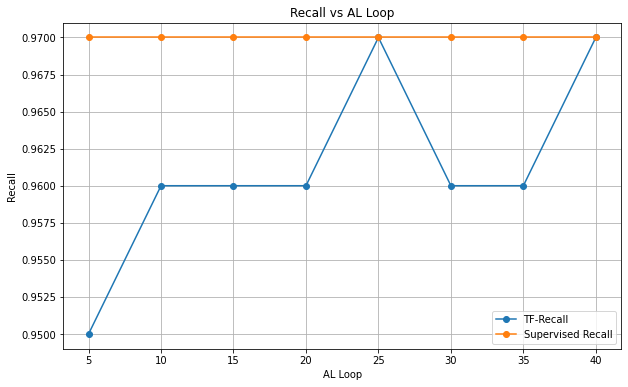

In [94]:
al_loop = [5,10,15,20,25,30,35,40]
f1_score = [0.83,0.90,0.91,0.94,0.94,0.96,0.96,0.96]
supervised_f1_score = [0.97,0.97,0.97,0.97,0.97,0.97,0.97,0.97]
precision = [0.74,0.84,0.87,0.92,0.92,0.96,0.96,0.96]
supervised_precision = [0.97,0.97,0.97,0.97,0.97,0.97,0.97,0.97]
recall = [0.95,0.96,0.96,0.96,0.97,0.96,0.96,0.97]
supervised_recall = [0.97,0.97,0.97,0.97,0.97,0.97,0.97,0.97]

# Create DataFrame
df_viz = pd.DataFrame({
    'AL_Loop': al_loop,
    'F1_Score': f1_score,
    'Supervised_F1_Score': supervised_f1_score,
    'Precision': precision,
    'Supervised_Precision': supervised_precision,
    'Recall': recall,
    'Supervised_Recall': supervised_recall
})


# Plot
plt.figure(figsize=(10, 6))

# Plot F1_Score
plt.plot(al_loop, recall, marker='o', label='TF-Recall')

# Plot Supervised_F1_Score
plt.plot(al_loop, supervised_recall, marker='o', label='Supervised Recall')

# Add labels and title
plt.title('Recall vs AL Loop')
plt.xlabel('AL Loop')
plt.ylabel('Recall')
plt.grid(True)
plt.legend()

# Show plot
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


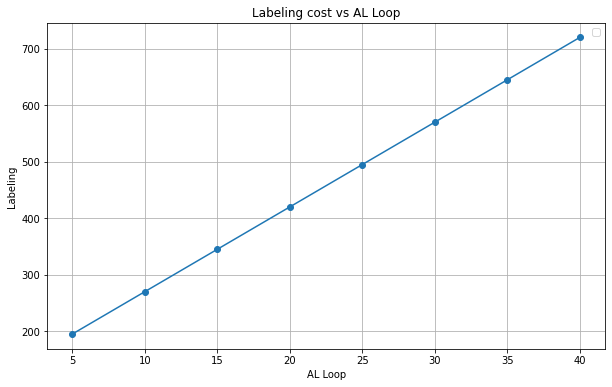

In [100]:
al_loop = [5,10,15,20,25,30,35,40]
number_of_labeled_record_pairs = [195,270,345,420,495,570,645,720]

# Plot
plt.figure(figsize=(10, 6))

# Plot F1_Score
plt.plot(al_loop, number_of_labeled_record_pairs, marker='o')

# Add labels and title
plt.title('Labeling cost vs AL Loop')
plt.xlabel('AL Loop')
plt.ylabel('Labeling')
plt.grid(True)
plt.legend()

# Show plot
plt.show()


# Visualization

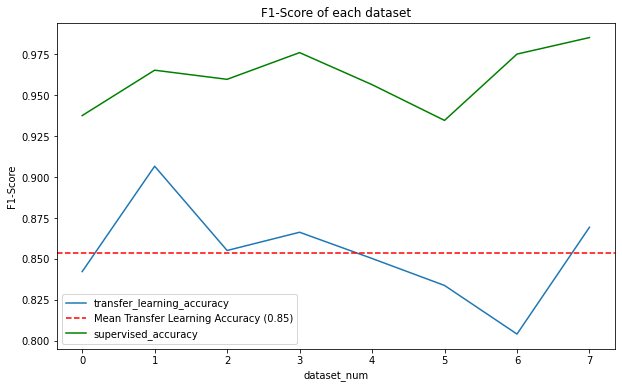

In [491]:
# Plot the line plot
ax = second_approach_vs_superived_df['transfer_learning_accuracy'].plot(kind='line', figsize=(10, 6), title='F1-Score of each dataset', xlabel='dataset_num', ylabel='F1-Score')

# Plot the mean line for 'transfer_learning_accuracy'
mean_value = second_approach_vs_superived_df['transfer_learning_accuracy'].mean()
ax.axhline(y=mean_value, color='r', linestyle='--', label=f'Mean Transfer Learning Accuracy ({mean_value:.2f})')

# Plot another line for another column (assuming column name is 'another_column')
second_approach_vs_superived_df['supervised_accuracy'].plot(ax=ax, kind='line', color='g', linestyle='-', label='supervised_accuracy')

# Add legend
plt.legend()

# Show plot
plt.show()



# Similarity Analysis 

In [56]:
mapping

{'4_5.csv': 1,
 '2_3.csv': 2,
 '2_5.csv': 3,
 '2_4.csv': 4,
 '1_2.csv': 5,
 '1_3.csv': 6,
 '3_5.csv': 7,
 '3_4.csv': 8,
 '1_4.csv': 9,
 '1_5.csv': 10}

In [94]:
folder_path = '/Users/abdulnaser/Desktop/Masterarbeit/metadatatransferlearning-main/meta_tl/data/sim_dataframes/music/'
first_cluster_files = ['4_5.csv','2_5.csv','2_4.csv','1_2.csv','1_4.csv','1_5.csv']
second_cluster_files = ['3_4.csv','2_3.csv','1_3.csv','3_5.csv']

list_of_dfs_first_cluster = []
list_of_dfs_second_cluster = []


# Iterate over files in the folder
for file_name in os.listdir(folder_path):
    # Check if the file is a CSV file
    if file_name.endswith('.csv'):
        # Construct the full file path
        file_path = os.path.join(folder_path, file_name)
        
        # Read the CSV file
        df = pd.read_csv(file_path)
        df = df.loc[df['is_match']==0]
        
        if file_name in first_cluster_files:
            list_of_dfs_first_cluster.append(df)
        
        else:
            list_of_dfs_second_cluster.append(df)
        
        
       

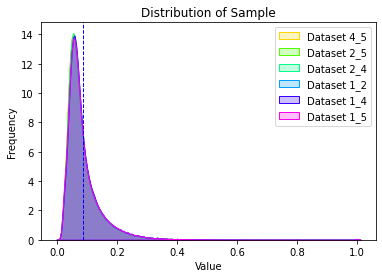

Mean: 0.08684671930859386
Standard Deviation: 0.06201157359700349


In [95]:
# Define a color palette with more colors
palette = sns.color_palette("hsv", len(list_of_dfs_first_cluster))

# Create an empty list to accumulate all data
all_data = []
first_cluster_files = ['4_5','2_5','2_4','1_2','1_4','1_5']
# Iterate over all DataFrames in the list
for i, df in enumerate(list_of_dfs_first_cluster):
    # Convert the column to numeric
    df['title_dice3'] = pd.to_numeric(df['title_dice3'], errors='coerce')
    
    # Append the data to the list
    all_data.extend(df['title_dice3'].dropna())  # Drop NaN values
    
    # Plot KDE plot for current DataFrame with specified color from the palette
    sns.kdeplot(df['title_dice3'], label=f'Dataset {first_cluster_files[i]}', shade=True, color=palette[i])

# Calculate mean and standard deviation for all data
mean_value = np.mean(all_data)
std_value = np.std(all_data)

# Plot mean line for all data
plt.axvline(mean_value, color='blue', linestyle='dashed', linewidth=1)

# Display legend
plt.legend()

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Sample')

# Show plot
plt.show()

# Print mean and standard deviation for all data
print("Mean:", mean_value)
print("Standard Deviation:", std_value)


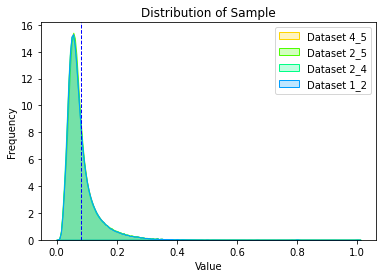

Mean: 0.08034823374551618
Standard Deviation: 0.055733314583082345


In [96]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assume list_of_dfs_first_cluster contains your list of DataFrames

# Define a color palette with more colors
palette = sns.color_palette("hsv", len(list_of_dfs_first_cluster))

# Create an empty list to accumulate all data
all_data = []
second_cluster_files = ['3_4','2_3','1_3','3_5']
# Iterate over all DataFrames in the list
for i, df in enumerate(list_of_dfs_second_cluster):
    # Convert the column to numeric
    df['title_dice3'] = pd.to_numeric(df['title_dice3'], errors='coerce')
    
    # Append the data to the list
    all_data.extend(df['title_dice3'].dropna())  # Drop NaN values
    
    # Plot KDE plot for current DataFrame with specified color from the palette
    sns.kdeplot(df['title_dice3'], label=f'Dataset {first_cluster_files[i]}', shade=True, color=palette[i])

# Calculate mean and standard deviation for all data
mean_value = np.mean(all_data)
std_value = np.std(all_data)

# Plot mean line for all data
plt.axvline(mean_value, color='blue', linestyle='dashed', linewidth=1)

# Display legend
plt.legend()

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Sample')

# Show plot
plt.show()

# Print mean and standard deviation for all data
print("Mean:", mean_value)
print("Standard Deviation:", std_value)


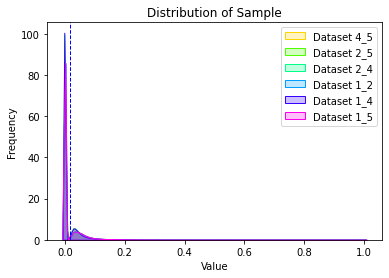

Mean: 0.01605947033052413
Standard Deviation: 0.03765509064026774


In [97]:
# Define a color palette with more colors
palette = sns.color_palette("hsv", len(list_of_dfs_first_cluster))

# Create an empty list to accumulate all data
all_data = []
first_cluster_files = ['4_5','2_5','2_4','1_2','1_4','1_5']
# Iterate over all DataFrames in the list
for i, df in enumerate(list_of_dfs_first_cluster):
    # Convert the column to numeric
    df['album_dice3'] = pd.to_numeric(df['album_dice3'], errors='coerce')
    
    # Append the data to the list
    all_data.extend(df['album_dice3'].dropna())  # Drop NaN values
    
    # Plot KDE plot for current DataFrame with specified color from the palette
    sns.kdeplot(df['album_dice3'], label=f'Dataset {first_cluster_files[i]}', shade=True, color=palette[i])

# Calculate mean and standard deviation for all data
mean_value = np.mean(all_data)
std_value = np.std(all_data)

# Plot mean line for all data
plt.axvline(mean_value, color='blue', linestyle='dashed', linewidth=1)

# Display legend
plt.legend()

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Sample')

# Show plot
plt.show()

# Print mean and standard deviation for all data
print("Mean:", mean_value)
print("Standard Deviation:", std_value)


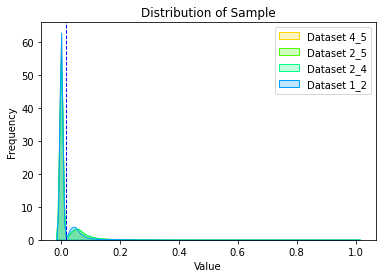

Mean: 0.017705795606032283
Standard Deviation: 0.04301043245044679


In [98]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assume list_of_dfs_first_cluster contains your list of DataFrames

# Define a color palette with more colors
palette = sns.color_palette("hsv", len(list_of_dfs_first_cluster))

# Create an empty list to accumulate all data
all_data = []
second_cluster_files = ['3_4','2_3','1_3','3_5']
# Iterate over all DataFrames in the list
for i, df in enumerate(list_of_dfs_second_cluster):
    # Convert the column to numeric
    df['album_dice3'] = pd.to_numeric(df['album_dice3'], errors='coerce')
    
    # Append the data to the list
    all_data.extend(df['album_dice3'].dropna())  # Drop NaN values
    
    # Plot KDE plot for current DataFrame with specified color from the palette
    sns.kdeplot(df['album_dice3'], label=f'Dataset {first_cluster_files[i]}', shade=True, color=palette[i])

# Calculate mean and standard deviation for all data
mean_value = np.mean(all_data)
std_value = np.std(all_data)

# Plot mean line for all data
plt.axvline(mean_value, color='blue', linestyle='dashed', linewidth=1)

# Display legend
plt.legend()

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Sample')

# Show plot
plt.show()

# Print mean and standard deviation for all data
print("Mean:", mean_value)
print("Standard Deviation:", std_value)


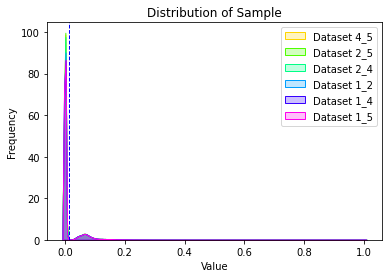

Mean: 0.01452585831024054
Standard Deviation: 0.04086121550031702


In [99]:
# Define a color palette with more colors
palette = sns.color_palette("hsv", len(list_of_dfs_first_cluster))

# Create an empty list to accumulate all data
all_data = []
first_cluster_files = ['4_5','2_5','2_4','1_2','1_4','1_5']
# Iterate over all DataFrames in the list
for i, df in enumerate(list_of_dfs_first_cluster):
    # Convert the column to numeric
    df['artist_dice3'] = pd.to_numeric(df['artist_dice3'], errors='coerce')
    
    # Append the data to the list
    all_data.extend(df['artist_dice3'].dropna())  # Drop NaN values
    
    # Plot KDE plot for current DataFrame with specified color from the palette
    sns.kdeplot(df['artist_dice3'], label=f'Dataset {first_cluster_files[i]}', shade=True, color=palette[i])

# Calculate mean and standard deviation for all data
mean_value = np.mean(all_data)
std_value = np.std(all_data)

# Plot mean line for all data
plt.axvline(mean_value, color='blue', linestyle='dashed', linewidth=1)

# Display legend
plt.legend()

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Sample')

# Show plot
plt.show()

# Print mean and standard deviation for all data
print("Mean:", mean_value)
print("Standard Deviation:", std_value)


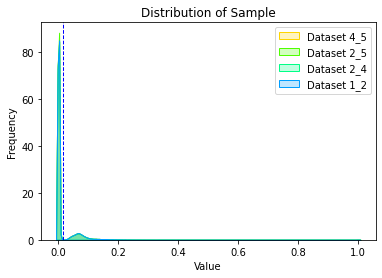

Mean: 0.01389643746836715
Standard Deviation: 0.03897663472485506


In [100]:
# Define a color palette with more colors
palette = sns.color_palette("hsv", len(list_of_dfs_first_cluster))

# Create an empty list to accumulate all data
all_data = []
second_cluster_files = ['3_4','2_3','1_3','3_5']
# Iterate over all DataFrames in the list
for i, df in enumerate(list_of_dfs_second_cluster):
    # Convert the column to numeric
    df['artist_dice3'] = pd.to_numeric(df['artist_dice3'], errors='coerce')
    
    # Append the data to the list
    all_data.extend(df['artist_dice3'].dropna())  # Drop NaN values
    
    # Plot KDE plot for current DataFrame with specified color from the palette
    sns.kdeplot(df['artist_dice3'], label=f'Dataset {first_cluster_files[i]}', shade=True, color=palette[i])

# Calculate mean and standard deviation for all data
mean_value = np.mean(all_data)
std_value = np.std(all_data)

# Plot mean line for all data
plt.axvline(mean_value, color='blue', linestyle='dashed', linewidth=1)

# Display legend
plt.legend()

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Sample')

# Show plot
plt.show()

# Print mean and standard deviation for all data
print("Mean:", mean_value)
print("Standard Deviation:", std_value)


# Number of positive and number of negative

In [113]:
sim_vector_files = [file for file in os.listdir('/Users/abdulnaser/Desktop/Masterarbeit/metadatatransferlearning-main/meta_tl/data/sim_dataframes/music') if file.endswith('.csv')]
count = 1
for sim_vector_file in sim_vector_files:
    print(sim_vector_file)
    sim_vector_file_path = os.path.join(path_to_sim_vector_folder,sim_vector_file)
    df = pd.read_csv(sim_vector_file_path)
    print(f"Dataframe {count}")
    # Count the occurrences of each value
    value_counts = df['is_match'].value_counts()
    
    print("Count of 0:", value_counts[0])
    print("Count of 1:", value_counts[1])
    
    count = count + 1
     

4_5.csv
Dataframe 1
Count of 0: 685530
Count of 1: 1777
2_3.csv
Dataframe 2
Count of 0: 747069
Count of 1: 1883
2_5.csv
Dataframe 3
Count of 0: 724445
Count of 1: 1189
2_4.csv
Dataframe 4
Count of 0: 707804
Count of 1: 1094
1_2.csv
Dataframe 5
Count of 0: 729157
Count of 1: 1845
1_3.csv
Dataframe 6
Count of 0: 735539
Count of 1: 1166
3_5.csv
Dataframe 7
Count of 0: 730577
Count of 1: 1210
3_4.csv
Dataframe 8
Count of 0: 705479
Count of 1: 1821
1_4.csv
Dataframe 9
Count of 0: 690575
Count of 1: 1090
1_5.csv
Dataframe 10
Count of 0: 713528
Count of 1: 1899


# Archiv

In [177]:
df_4_5 = pd.read_csv(os.path.join('/Users/abdulnaser/Desktop/Masterarbeit/metadatatransferlearning-main/meta_tl/data/sim_dataframes/music','4_5.csv'))
df_3_5 = pd.read_csv(os.path.join('/Users/abdulnaser/Desktop/Masterarbeit/metadatatransferlearning-main/meta_tl/data/sim_dataframes/music','2_5.csv'))

candidate_model_df_processed_4_5 = prepare_dataframe(df_4_5)
candidate_model_df_processed_3_5 = prepare_dataframe(df_3_5)
print(candidate_model_df_processed_4_5.shape[0])
print(candidate_model_df_processed_3_5.shape[0])

candidate_model_df_processed_4_5 = candidate_model_df_processed_4_5.drop(columns=['is_match'])
candidate_model_df_processed_3_5 = candidate_model_df_processed_3_5.drop(columns=['is_match'])
print(candidate_model_df_processed_4_5.columns)
print(candidate_model_df_processed_3_5.columns)
candidate_model_df_processed_4_5['new_match'] = 0
candidate_model_df_processed_3_5['new_match'] = 1

# Shuffle the rows of each DataFrame randomly
df1_shuffled = candidate_model_df_processed_4_5.sample(frac=1, random_state=42)  # Shuffle df1
df2_shuffled = candidate_model_df_processed_3_5.sample(frac=1, random_state=42)  # Shuffle df2
print(df1_shuffled.shape[0])
print(df2_shuffled.shape[0])
# Concatenate the shuffled DataFrames
concatenated_df = pd.concat([df1_shuffled, df2_shuffled], ignore_index=True)
print(concatenated_df.shape[0])
X = concatenated_df.drop(columns=['new_match'])
y = concatenated_df['new_match']

# Create an XGBoost classifier
xgb_clf = xgb.XGBClassifier(objective='binary:logistic')

# Perform cross-validation
cv_results = cross_val_score(xgb_clf, X, y, cv=5, scoring='accuracy')
print(cv_results.mean())



687307
725634
Index(['title_dice3', 'album_dice3', 'artist_dice3'], dtype='object')
Index(['title_dice3', 'album_dice3', 'artist_dice3'], dtype='object')
687307
725634
1412941
0.5361497754490164


In [178]:
df_4_5 = pd.read_csv(os.path.join('/Users/abdulnaser/Desktop/Masterarbeit/metadatatransferlearning-main/meta_tl/data/sim_dataframes/music','4_5.csv'))
df_4_5 = prepare_dataframe(df_4_5)
#df_4_5 = df_4_5.loc[df_4_5['is_match']==1]

df_2_5 = pd.read_csv(os.path.join('/Users/abdulnaser/Desktop/Masterarbeit/metadatatransferlearning-main/meta_tl/data/sim_dataframes/music','2_5.csv'))
df_2_5 = prepare_dataframe(df_2_5)
#df_3_4 = df_3_4.loc[df_3_4['is_match']==1]


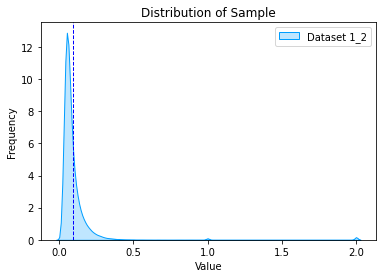

Mean: 0.0955640449955807
Standard Deviation: 0.14435639860700483


In [133]:
# Define a color palette with more colors
palette = sns.color_palette("hsv", len(list_of_dfs_first_cluster))


# Plot KDE plot for current DataFrame with specified color from the palette
sns.kdeplot(df_4_5['title_dice3'], label=f'Dataset {first_cluster_files[i]}', shade=True, color=palette[i])

# Calculate mean and standard deviation for all data
mean_value = np.mean(df_4_5['title_dice3'])
std_value = np.std(df_4_5['title_dice3'])

# Plot mean line for all data
plt.axvline(mean_value, color='blue', linestyle='dashed', linewidth=1)

# Display legend
plt.legend()

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Sample')

# Show plot
plt.show()

# Print mean and standard deviation for all data
print("Mean:", mean_value)
print("Standard Deviation:", std_value)


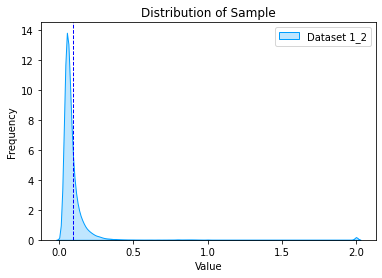

Mean: 0.09108013814601892
Standard Deviation: 0.1466975803017488


In [134]:
# Define a color palette with more colors
palette = sns.color_palette("hsv", len(list_of_dfs_first_cluster))


# Plot KDE plot for current DataFrame with specified color from the palette
sns.kdeplot(df_3_4['title_dice3'], label=f'Dataset {first_cluster_files[i]}', shade=True, color=palette[i])

# Calculate mean and standard deviation for all data
mean_value = np.mean(df_3_4['title_dice3'])
std_value = np.std(df_3_4['title_dice3'])

# Plot mean line for all data
plt.axvline(mean_value, color='blue', linestyle='dashed', linewidth=1)

# Display legend
plt.legend()

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Sample')

# Show plot
plt.show()

# Print mean and standard deviation for all data
print("Mean:", mean_value)
print("Standard Deviation:", std_value)


In [183]:
df_2_5.loc[df_2_5['title_dice3']==2]

,title_dice3,album_dice3,artist_dice3,is_match
511540,2.0,0.000000,0.000000,0.0
511541,2.0,0.000000,0.031746,0.0
511542,2.0,0.042553,0.000000,0.0
511543,2.0,0.000000,0.000000,0.0
511544,2.0,0.000000,0.000000,0.0
...,...,...,...,...
512865,2.0,0.000000,2.000000,0.0
512866,2.0,0.000000,2.000000,0.0
512867,2.0,0.000000,2.000000,0.0
512868,2.0,0.000000,2.000000,0.0


In [182]:
df_4_5.loc[df_4_5['title_dice3']==2]

,title_dice3,album_dice3,artist_dice3,is_match
0,2.0,0.000000,2.0,0.0
1,2.0,0.058824,2.0,0.0
2,2.0,0.000000,2.0,0.0
3,2.0,0.000000,2.0,0.0
4,2.0,0.000000,2.0,0.0
...,...,...,...,...
2845,2.0,0.000000,0.0,0.0
2846,2.0,0.026667,0.0,0.0
2847,2.0,0.000000,0.0,0.0
2848,2.0,0.023529,0.0,0.0


In [144]:
mapping

{'4_5.csv': 1,
 '2_3.csv': 2,
 '2_5.csv': 3,
 '2_4.csv': 4,
 '1_2.csv': 5,
 '1_3.csv': 6,
 '3_5.csv': 7,
 '3_4.csv': 8,
 '1_4.csv': 9,
 '1_5.csv': 10}

In [ ]:
2,6,7,8
1,3,4,5,9,10